# Inversion example of diffusion + tracer mineral (uranium salt) dissolution inversion in 2d

- Importation of the required modules

In [140]:
import copy
import logging
import os
from enum import Enum, auto
from pathlib import Path
from typing import Dict, Generator, Iterable, List, Sequence, Tuple, Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import nested_grid_plotter as ngp
import numpy as np
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
import pyrtid.utils.spde as spde
import scipy
import tomli
from IPython.display import HTML
from matplotlib.animation import HTMLWriter
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon
from pyesmda import get_ensemble_variance
from pyesmda.localization import FixedLocalization, distances_to_weights_beta_cumulative
from pyrtid.inverse.params import (
    get_gridded_archived_gradients,
    get_param_values,
)
from pyrtid.inverse.regularization import (
    GeostatisticalRegularizator,
    SparseInvCovarianceMatrix,
)
from pyrtid.inverse.regularization.covariances import get_explained_var
from pyrtid.utils import (
    GaussianFilter,
    StrEnum,
    get_pts_coords_regular_grid,
    indices_to_node_number,
    node_number_to_indices,
)
from pyrtid.utils.types import NDArrayFloat, NDArrayInt
from pyrtid.utils.wellfield import gen_wells_coordinates
from scipy.interpolate import interp1d
from scipy.sparse import csc_array, csr_array, lil_array
from scipy.spatial import distance_matrix
from shapely.geometry import Polygon as ShapelyPolygon
from shapely.geometry import box as ShapelyBox
from shapely.ops import cascaded_union
from sksparse.cholmod import cholesky

- Set-up logging level

In [75]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions

In [76]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.0
INFO:root:matplotlib                  = 3.6.2
INFO:root:nested_grid_plotter         = 0.1.2
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Random number generator with a given seed for reproducible results

In [77]:
rng = np.random.default_rng(2023)

- Create a directory to store the exported figures

In [78]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [79]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    # "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

- Define a flag to turn off/on the complete notebook run

In [80]:
class Lg(StrEnum):
    FRENCH = "french"
    ENGLISH = "english"


with open("config.toml", "rb") as f:
    data = tomli.load(f)

    is_run_all = data["is_run_all"]
    # whether to run asm inversion
    is_run_asm = data["is_run_asm"] or is_run_all
    # whether to run pcga inversion
    is_run_pcga = data["is_run_pcga"] or is_run_all
    # whether to run esmda inversion
    is_run_esmda = data["is_run_esmda"] or is_run_all
    # whether to run sies inversion
    is_run_sies = data["is_run_sies"] or is_run_all
    # whether to run the code parallel
    is_parallel = data["is_parallel"]
    # number of workers for the parallel execution
    max_workers = data["max_workers"]
    # language for the plot labels
    language = ["language"]
    # number of principal component for the inversion with PCGA
    n_pc = data["n_pc"]
    # number of fields for the ensemble smoothers
    n_fields_es = data["n_fields_es"]

    # Needed when we generate the ensemble
    is_run_ensembles = is_run_esmda or is_run_sies

## Forward problem

- Define a very simple pure diffusion case in 1D.

In [81]:
# Grid
nx = 140  # number of voxels along the x axis + 4 * 2 for the borders (regularization)
ny = 34  # number of voxels along the y axis
nz = 1
dx = 5.0  # voxel dimension along the x axis
dy = 1.0  # voxel dimension along the y axis
dz = 80.0

# Timesteps
duration_in_days = 300
duration_in_seconds = duration_in_days * 3600 * 24
duration_in_days_inv = 90  # used for inversion
duration_in_seconds_inv = duration_in_days_inv * 3600 * 24
dt_init = 3600 * 6  # timestep in seconds
dt_min = dt_init / 2
dt_max = dt_init * 2
courant_factor = 10

# Hydro parameters
flow_regime = "transient"
diffusion_coef = 1e-10  # general initial diffusion coefficient [m2/s]
permeability = 1e-4  # general permeability
porosity = 0.23  # general porosity [fraction]
storage_coefficient = 1e-3

# Chemistry parameters
c0 = 1.0e-10  # general initial concentration [molal]
c_inj = 1.0  # molal
stocoef = 100

M0 = 0.001  # mineral grade [mol/kg] -> kg of water
kv = -1e-7  # kinetic rate,       [mol/m2/s]
moleweight = 270.0  # molar weight [g/mol]
surface = 500  # cm2/g
As = moleweight * surface / 1e4  # specific area [m2/mol]
logK = 3.2
Ks = 1.0 / pow(10, logK)  # solubility constant [no unit]

## Creation of a roll-front system

- Definition of lithotypes

In [82]:
class LithoCodes(Enum):
    CLAY = auto()
    OXIDIZED = auto()
    MINERALIZED = auto()
    REDUCED = auto()


# Array with facies ids (between 0 and 2 matching LithoCodes)
facies_ids = np.zeros((nx, ny))
# Array with reference uranium grades
reference_grades = np.zeros((nx, ny))

# Initially, place all as reduced
facies_ids[:, :] = LithoCodes.REDUCED.value

# Add impermeable layer of 2m on top and bottom of the reservoir
facies_ids[:, :2] = LithoCodes.CLAY.value
facies_ids[:, -2:] = LithoCodes.CLAY.value

# Add a mineralization

In [83]:
def create_circular_inversed_gradient_2D(
    nx: int,
    ny: int,
    scale_x: float,
    scale_y: float,
    center_x: float,
    center_y: float,
    beta,
    max_dist: float,
) -> NDArrayFloat:
    """
    Create a decentered elipse with values bwteen zero and 1.

    Values are zero at the elipse center and gradually increasing to one.

    Parameters
    ----------
    nx : int
        Number of grid cells along the x axis.
    ny : int
        Number of grid cells along the y axis.
    scale_x : float
        Scaling factor along x.
    scale_y : float
        Scaling factor along y.
    center_x : float
        X coordinate of the elipse center.
    center_y : float
        Y coordinate of the elipse center.
    beta : _type_
        Beta coefficient for the gradient sharpness. The higher the sharper.
    max_dist : float
        Max scaled distance. Above that distance from the elipse center, values are
        zero.

    Returns
    -------
    NDArrayFloat
        _description_
    """
    # create the grid coordinates
    coords = get_pts_coords_regular_grid((1, 1), (nx, ny))
    # compute the distance of each grid mesh to the elipse center.
    r = np.sqrt(
        ((coords[:, 0] - center_x) / scale_x) ** 2
        + ((coords[:, 1] - center_y) / scale_y) ** 2
    )
    # compute the weight between zero and 1.
    tmp = distances_to_weights_beta_cumulative(r, beta)

    # inverse the field
    tmp = -tmp + 1
    # apply the max diatnce
    tmp[r > max_dist] = 0.0
    # reshape to (nx, ny)
    return tmp.reshape(nx, ny, order="F")

In [84]:
# maximum uraninite grade
max_grade_ppm = 600.0
# cut off grade -> below that value, it is considered as oxidized
cut_off_grade_ppm = 150.0
reference_grades_ppm = (
    create_circular_inversed_gradient_2D(nx, ny, 251, 35, -30, ny * dy / 2, 3.0, 0.6)
    * max_grade_ppm
)

# Adjust the uranium grade with the clays
reference_grades_ppm[facies_ids == LithoCodes.CLAY.value] = 0.0

# Convert the grid cells with non null grade to mineralized
facies_ids[reference_grades_ppm > 0] = LithoCodes.MINERALIZED.value

# Convert the grid cells with non null grade but below the cut-off to oxidized
mask = np.logical_and(
    reference_grades_ppm < cut_off_grade_ppm, reference_grades_ppm > 0
)
facies_ids[mask] = LithoCodes.OXIDIZED.value

# Add two clay lengthes
facies_ids[20:40, 23:24] = LithoCodes.CLAY.value
facies_ids[22:45, 22:23] = LithoCodes.CLAY.value

facies_ids[82:100, 6:7] = LithoCodes.CLAY.value
facies_ids[80:105, 5:6] = LithoCodes.CLAY.value

facies_ids[100:, 26:27] = LithoCodes.CLAY.value
facies_ids[110:, 25:26] = LithoCodes.CLAY.value

# Adjust the uranium grade with the clays again
reference_grades_ppm[facies_ids == LithoCodes.CLAY.value] = 0.0

Note about krr: older limbs of the roll-front deposit and in residual mineralized bodies in the oxidized rock upstream of the main ore. Radium also forms diffuse halos up- and downstream of the  deposit, leading to elevated 226Ra/238U activity ratios that are generally greater than 1. Real systems are more heterogeneous than this idealized view, however, with 226Ra/238U activity ratios in ore deposits observed to range from 0.2 to 3 on average and reach maximums of 10 to >30 at low uranium concentrations (<100 ppm).

In [131]:
URa = 150.0 / (reference_grades_ppm)
URa = np.clip(URa, 0.0, 10.0)
URa[np.isnan(krr)] = 0.0
URa[reference_grades_ppm <= 0.0] = 0.0

/tmp/ipykernel_14135/2484360363.py:1: RuntimeWarning: divide by zero encountered in divide
  URa = 150.0 / (reference_grades_ppm)


- Plot the facies and the grades

Text(0.02, 0.5, 'Z [m]')

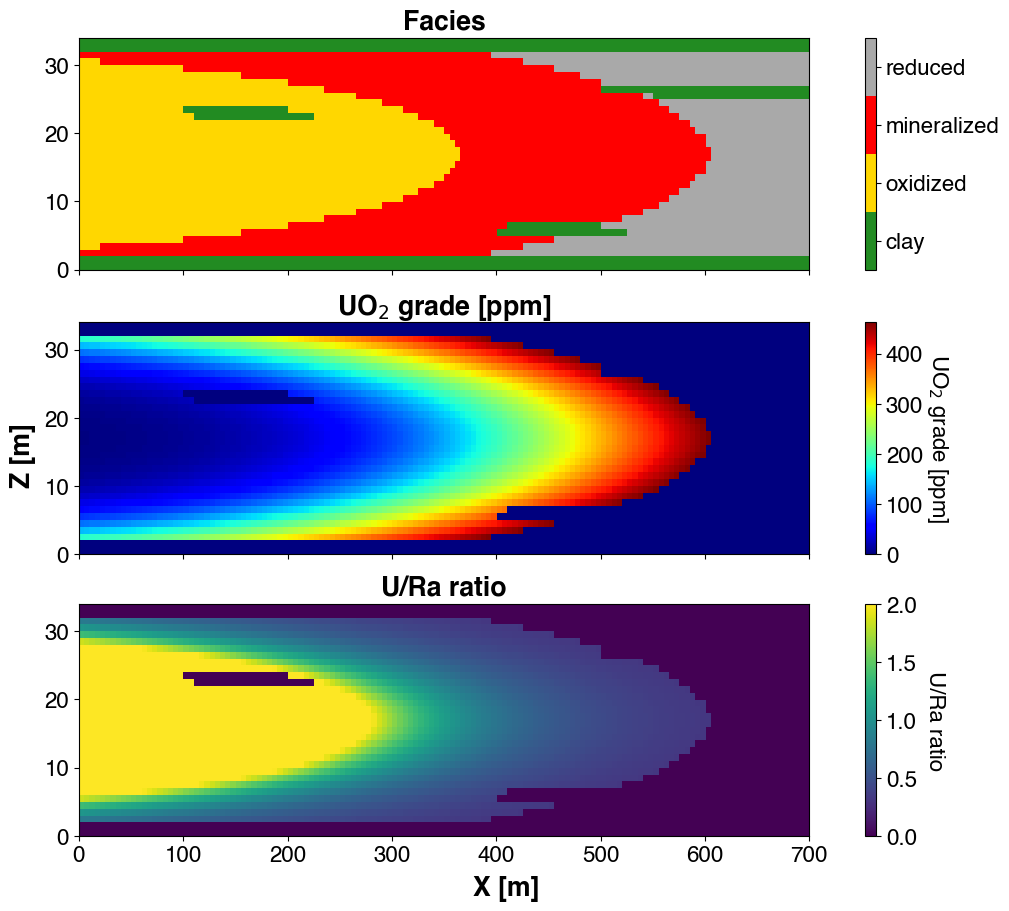

In [132]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 9)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=True, sharex=True)
    },
)

# 1) Plot facies
cmap_4f = ListedColormap(["forestgreen", "gold", "r", "darkgrey"])
target_names_4f = ["clay", "oxidized", "mineralized", "reduced"]

ax = plotter.ax_dict["ax1-1"]
# Set the vmin/vmax so that labels are centered on each block
psm = ax.imshow(
    facies_ids.T - 1.5,
    cmap=cmap_4f,
    rasterized=True,
    vmin=-0.5,
    vmax=len(target_names_4f) - 0.5,
    extent=[0.0, nx * dx, 0.0, ny * dy],
    origin="lower",
    aspect="auto",
)
# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: target_names_4f[val])
# We must be sure to specify the ticks matching our target names
plt.colorbar(
    psm, ticks=[_v for _v in range(len(target_names_4f))], ax=ax, format=formatter
)
# Add a title
ax.set_title("Facies", fontweight="bold")


# 2) Plot grades
ngp.multi_imshow(
    axes=[plotter.ax_dict["ax2-1"]],
    fig=plotter.fig,
    data={
        "UO$_2$ grade [ppm]": reference_grades_ppm,
    },
    imshow_kwargs={
        "cmap": "jet",
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    cbar_title="UO$_2$ grade [ppm]",
)

# 3) Plot the desequilibria
ngp.multi_imshow(
    axes=[plotter.ax_dict["ax3-1"]],
    fig=plotter.fig,
    data={
        "U/Ra ratio": URa,
    },
    imshow_kwargs={
        "cmap": "viridis",
        "vmin": 0.0,
        "vmax": 2.0,
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    cbar_title="U/Ra ratio",
)

plotter.fig.supxlabel("X [m]", fontweight="bold")
plotter.fig.supylabel("Z [m]", fontweight="bold")

- Add some drilling to estimate the uranium grade (exploration phase)

INFO:root:n_explo_wells = 7
INFO:root:explo_wells_x_pos_m = [ 50. 150. 250. 350. 450. 550. 650.]


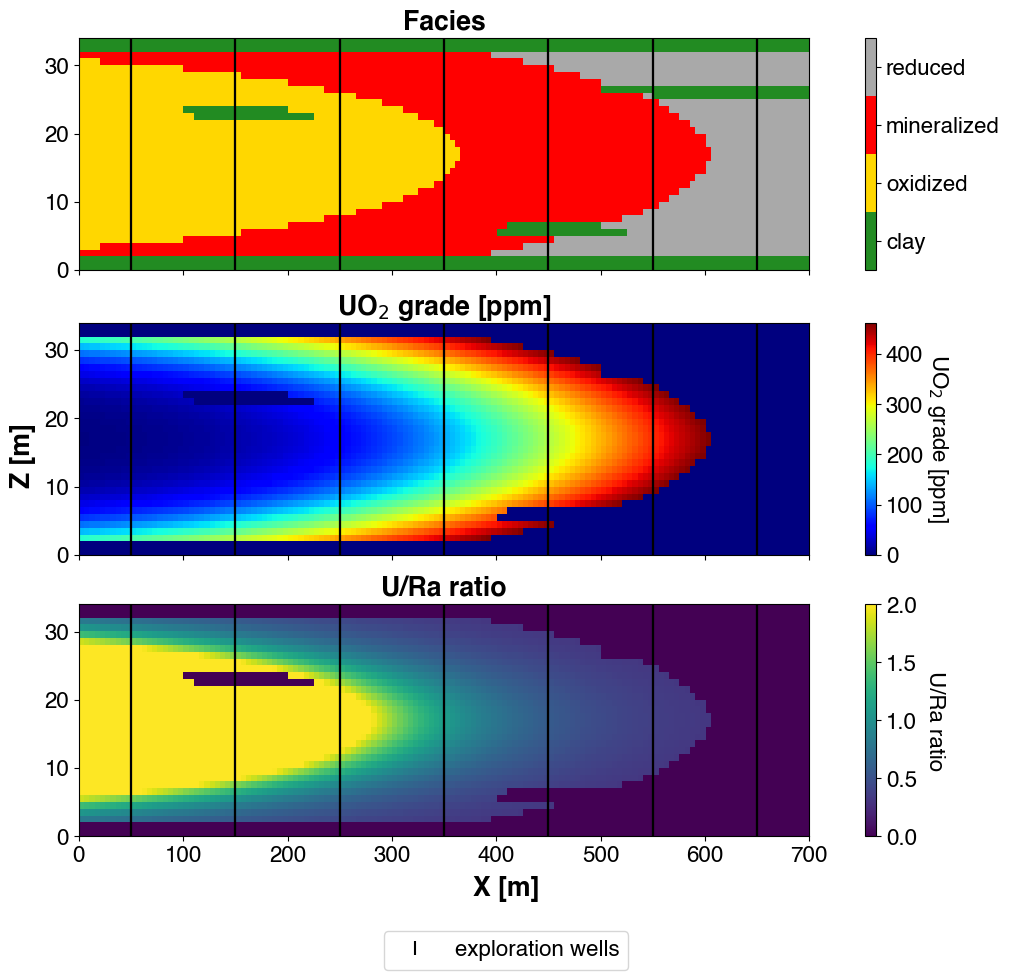

In [129]:
explo_wells_spacing_m = 100
n_explo_wells = int((nx * dx) / explo_wells_spacing_m)
logging.info(f"n_explo_wells = {n_explo_wells}")

_first_pos = (nx * dx - explo_wells_spacing_m * (n_explo_wells - 1)) / 2
_last_pos = explo_wells_spacing_m * (n_explo_wells - 1) + _first_pos
explo_wells_x_pos_m = np.linspace(_first_pos, _last_pos, n_explo_wells)
explo_wells_x_pos_idx = np.array(explo_wells_x_pos_m / dx, dtype=np.int32)

logging.info(f"explo_wells_x_pos_m = {explo_wells_x_pos_m}")

for ax in plotter.axes:
    for _pos in explo_wells_x_pos_m:
        ax.axvline(_pos, color="k")

from matplotlib.lines import Line2D

handle = Line2D(
    [], [], color="k", marker="|", markeredgewidth=1.5, linestyle="None", markersize=10
)
plotter.add_extra_legend_item("ax2-1", handle=handle, label="exploration wells")
plotter.add_fig_legend()

fname = "grade_and_facies"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

# Show the figure
plotter.fig

- Interpolation of the uranium values from the concentration measured along the drill cores. We also take into account the effect of 226Ra/238U disequilibria arising from the differential mobility of uranium and radium during groundwater transport. 1D reactive transport models were developed to investigate the long-term effects of retention processes (UO2(am) precipitation, U(VI) and Ra sorption on smectite,
quote: grozevaReactiveTransportModeling2022

![URa](./1-s2.0-S037567422200019X-ga1.jpg)

/tmp/ipykernel_14135/3378302299.py:2: RuntimeWarning: divide by zero encountered in divide
  eRa_ppm = reference_grades_ppm * (1 + np.where(URa == 0, 0, 1 / URa))


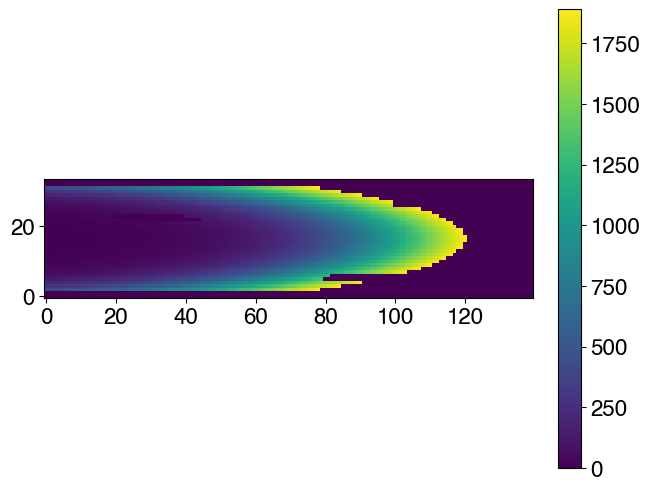

In [151]:
# uranium + radium
eRa_ppm = reference_grades_ppm * (1 + np.where(URa == 0, 0, 1 / URa))
# Get the conditionning data
plt.imshow(eRa_ppm.T, origin="lower")
plt.colorbar()
eRa_cond_ppm = eRa_ppm[explo_wells_x_pos_idx, :].ravel(order="F")

- Get the conditionning points coordinates

In [230]:
dat_coords = np.array(np.meshgrid(explo_wells_x_pos_idx, np.arange(0, ny))).reshape(
    2, -1
)
# Get the node numbers
dat_nn: NDArrayInt = indices_to_node_number(dat_coords[0, :], nx, dat_coords[1, :])

In [165]:
grid_pts = get_pts_coords_regular_grid((dx, dy), (nx, ny)).reshape(nx, ny, 2, order="F")
pts_cond = grid_pts[explo_wells_x_pos_idx, :].reshape(-1, 2, order="F")
nn_cond = get
eRa_cond_ppm.shape

(238,)

- Add error to the measure points

In [249]:
dat_val_wrong.shape

(238,)

In [258]:
# Generate new points with error -> systematic bias 200 ppm + some variance on the mesures
eRa_cond_ppm_noisy = eRa_cond_ppm * (
    1 + np.random.default_rng(2048).normal(scale=0.1, size=eRa_cond_ppm.size)
)

# overestimation of the area U/Ra
estimated_ura = 1.5

dat_val_wrong = eRa_cond_ppm_noisy / (1.0 + 1.0 / estimated_ura)

# Condition with the exact data -> we assume a large noise over the data
dat_var_init = np.ones(dat_val_wrong.size) * (100**2)

# Compute the average on the data points (trend)
estimated_mean = np.average(dat_val_wrong)
estimated_std = float(np.std(dat_val_wrong))

alpha = 3
kappa = 1 / 20

# Create a precison matrix
Q_init = spde.get_precision_matrix(
    nx, ny, 1, dx, dy, 1.0, kappa, alpha, spatial_dim=2, sigma=estimated_std
)
Q_init_c = spde.condition_precision_matrix(Q_init, dat_nn, dat_var_init)

# Decompose with cholesky
cholQ_init = cholesky(Q_init)
cholQ_init_c = cholesky(Q_init_c)

estimate_grade_simu = (
    spde.simu_c(
        cholQ_init,
        Q_init_c,
        cholQ_init_c,
        dat_val_wrong - estimated_mean,
        dat_nn,
        dat_var_init,
        random_state=2063,
    )
    .reshape(ny, nx)
    .T
    + estimated_mean
)

# estimate_grade_simu = np.abs(
#     spde.kriging(
#         Q_init_c,
#         dat_val_wrong - estimated_mean,
#         dat_nn,
#         cholQ_init_c,
#         dat_var_init,
#     )
#     .reshape(ny, nx)
#     .T
#     + estimated_mean
# )

In [263]:
dat_val_wrong.shape

(238,)

In [268]:
pts_cond.shape

(238, 2)

array([  0,  35, 189, 210,  42,  49, 182,  56,  63,  70, 175,  77, 224,
        84, 168,  91,  98, 105, 161, 112, 119, 154, 126, 133, 217, 140,
       231,  28, 147,  14,  21, 203, 196,   7, 211,  85,  57, 113,   8,
        64, 106, 176, 162,  71,  99,  92, 225,  15,  78, 169, 232, 120,
       183,  29, 155, 141,   1, 148,  36, 190, 218,  22,  43, 134, 127,
        50, 204, 197, 121, 156, 163, 135, 100, 128,  93, 205, 219,   2,
       114, 107, 170, 142,   9, 149,  86,  72,  44, 184,  65,  23,  51,
       198, 177, 226, 212,  37, 191,  79, 233,  58,  30,  16, 122,  52,
       129,  45,  59, 150,   3,  24,  38, 136, 192,  31, 185, 157, 171,
       115, 213, 199, 164,  10,  73,  80, 143, 101,  94,  17, 206,  66,
       108, 220, 227, 178, 234,  87, 172, 193, 151, 165, 158, 186, 214,
       200, 179, 207,  25,  60,  67,  46,  74,  81,  39,  88,  32,  95,
       228, 102, 221, 109,  53,  18, 144,   4, 137, 130, 123, 235,  11,
       116, 201,  33, 208,  19, 194,  40, 187,   5,  12,  47, 22

array([[2.500e+00, 2.500e+00, 2.500e+00, ..., 6.975e+02, 6.975e+02,
        6.975e+02],
       [5.000e-01, 1.500e+00, 2.500e+00, ..., 3.150e+01, 3.250e+01,
        3.350e+01]])

In [284]:
# dat_coords
# order = np.argsort(pts_cond[:, 0])
# sp.interpolate.interpn((pts_cond[order, 0], pts_cond[order, 1]), dat_val_wrong.reshape(-1, 1)[order], grid_pts.reshape(-1, 2).T)

ValueError: The points in dimension 0 must be strictly ascending or descending

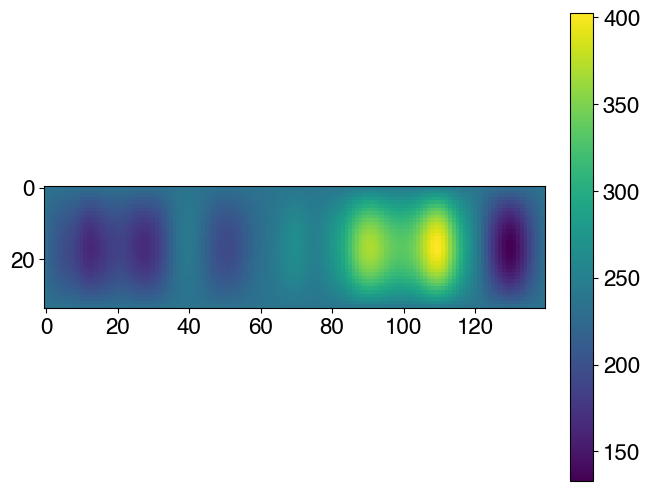

In [286]:
plt.imshow(estimate_grade_simu.T)
plt.colorbar()

NameError: name 'estimated_grades_ppm' is not defined

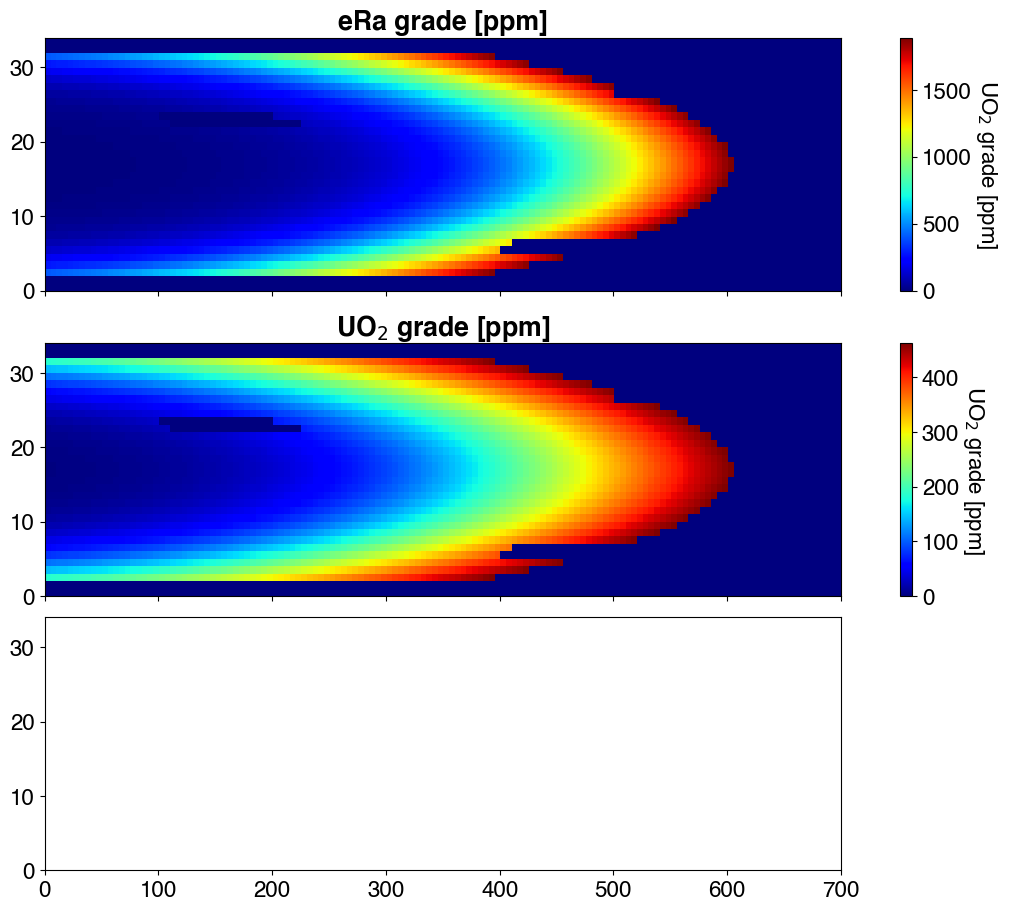

In [139]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 9)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=True, sharex=True)
    },
)

# 1) Plot eRa
ngp.multi_imshow(
    axes=[plotter.ax_dict["ax1-1"]],
    fig=plotter.fig,
    data={
        "eRa grade [ppm]": eRa_ppm,
    },
    imshow_kwargs={
        "cmap": "jet",
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    cbar_title="UO$_2$ grade [ppm]",
)

# 2) Plot reference grades
ngp.multi_imshow(
    axes=[plotter.ax_dict["ax2-1"]],
    fig=plotter.fig,
    data={
        "UO$_2$ grade [ppm]": reference_grades_ppm,
    },
    imshow_kwargs={
        "cmap": "jet",
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    cbar_title="UO$_2$ grade [ppm]",
)

# 3) Plot initial guess grades
ngp.multi_imshow(
    axes=[plotter.ax_dict["ax3-1"]],
    fig=plotter.fig,
    data={
        "U/Ra ratio": estimated_grades_ppm,
    },
    imshow_kwargs={
        "cmap": "jet",
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    cbar_title="U/Ra ratio",
)

plotter.fig.supxlabel("X [m]", fontweight="bold")
plotter.fig.supylabel("Z [m]", fontweight="bold")

In [13]:
# Drilling every 100 meters

In [ ]:
def create_variance_circle(
    coords: NDArrayFloat,
    var_min: float,
    var_max: float,
    beta: float,
    scaling_factor: float,
) -> NDArrayFloat:
    """_summary_

    Parameters
    ----------
    coords : NDArrayFloat
        Points coordinates (2, npts).
    var_min : float
        _description_
    var_max : float
        _description_

    Returns
    -------
    NDArrayFloat
        _description_
    """
    center_x = (np.max(coords[:, 0]) - np.min(coords[:, 0])) / 2
    center_y = (np.max(coords[:, 1]) - np.min(coords[:, 1])) / 2
    r = (
        np.sqrt((coords[:, 0] - center_x) ** 2 + (coords[:, 1] - center_y) ** 2)
        / scaling_factor
    )

- Creation of a network of injectors and producers in shape of hexagons.

In [9]:
# locations in the grid
# selection = index of cells to select. Cells are sorted by y, and if that's equal by x (increasing order).
cell_radius = 40.0
inj_grid_coordinates, prod_grid_coordinates, polygons = gen_wells_coordinates(
    -5.0,
    85.0,
    175.0,
    235.0,
    radius=cell_radius,
    rotation=-30,
    selection=[0, 1, 2, 4, 5, 6, 7],
)

- Get the indices in the grid

In [10]:
prod_grid_indices = np.array(
    [
        np.array(prod_grid_coordinates).T[0] // dx,
        np.array(prod_grid_coordinates).T[1] // dy,
    ],
    dtype=np.int32,
).T

inj_grid_indices = np.array(
    [
        np.array(inj_grid_coordinates).T[0] // dx,
        np.array(inj_grid_coordinates).T[1] // dy,
    ],
    dtype=np.int32,
).T

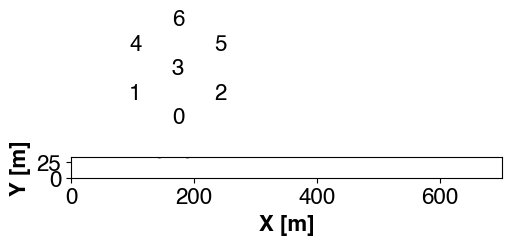

In [11]:
plotter_wf = ngp.NestedGridPlotter(fig_params={"figsize": (5, 5)})

for i, j in inj_grid_coordinates:
    plotter_wf.ax_dict["ax1-1"].plot(i, j, "ko")

for i, j in prod_grid_coordinates:
    plotter_wf.ax_dict["ax1-1"].plot(i, j, "ro")

patches = []
for polygon in polygons:
    # Add the polygon to the collection of patches
    xy = np.array(polygon)
    patches.append(Polygon(xy, closed=True, facecolor=None))
    # Plot the number of the polygon
p = PatchCollection(patches, alpha=0.75)
p.set_facecolors("white")
p.set_edgecolors("darkgrey")
p.set_linewidth(0.8)
p.set_linestyle("-")
plotter_wf.ax_dict["ax1-1"].add_collection(p)

for i, prod_coords in enumerate(prod_grid_coordinates):
    plotter_wf.ax_dict["ax1-1"].text(prod_coords[0] - 2, prod_coords[1] + 8, i)

plotter_wf.ax_dict["ax1-1"].set_aspect("equal", adjustable="box")
plotter_wf.ax_dict["ax1-1"].set_xlim(0, nx * dx)
plotter_wf.ax_dict["ax1-1"].set_ylim(0, ny * dy)
plotter_wf.ax_dict["ax1-1"].set_xlabel("X [m]", fontweight="bold")
plotter_wf.ax_dict["ax1-1"].set_ylabel("Y [m]", fontweight="bold")

fname = "7_cells_wellfield"
for format in ["png", "pdf"]:
    plotter_wf.fig.savefig(
        str(fig_save_path.joinpath(f"{fname}.{format}")), format=format
    )

In [12]:
prod_grid_coordinates[0]

(165.85680518387326, 80.0480947161671)

- Make some selection

In [ ]:
mpl_polygons = []
shapely_polygons = []

# Iterate the polygons to create matplotlib and shapely polygon instances
for polygon in polygons:
    # Add the polygon to the collection of patches
    xy = np.array(polygon)
    mpl_polygons.append(Polygon(xy, closed=True, facecolor=None))
    shapely_polygons.append(ShapelyPolygon(xy))

# Generate well field polygons
full_box = ShapelyBox(0.0, 0.0, nx * dx, ny * dy)  # polygon covering all the grid
inner_area = cascaded_union(shapely_polygons)  # polygon covering the well-field area
buffered_inner_area = inner_area.buffer(10.0)  # add a 10 m buffer around the
buffered_external_area = full_box.difference(
    buffered_inner_area
)  # ouside well-field area

- Create the flowrates for the wells: 12 m3/h decreasing following an exponential... for the producers with a balanced injection (2 m3/h per associated cell for the injectors).

In [ ]:
def gen_flowrates(amplitude: float, coef: float, nt: int, dt: float) -> NDArrayFloat:
    """Generate flowrates with a given amplitude and decrease coefficient.

    Parameters
    ----------
    amplitude : float
        Amplitude in m3/h.
    coef : float
        Decrease coefficient.
    nt : int
        Number of timesteps
    dt : float
        Timesteps.

    Returns
    -------
    np.ndarray
        The flowrates.
    """
    return amplitude * np.exp(coef * np.arange(nt) * dt)

- Generate a flowrates with an initial amplitude at 1 m3/h and plot it
- For now steady state

In [ ]:
init_prod_flowrates = 8.0  # m3/s
flowrates = init_prod_flowrates * gen_flowrates(
    1.0, -0.0015, duration_in_days + 1, dt=1.0
)  # m3/h
time_in_days = np.arange(duration_in_days + 1)
# plt.plot(np.arange(nt + 1) * dt / 3600 / 24, flowrates)
# plt.ylim(0.0, init_prod_flowrates * 1.1)

plt.plot(np.arange(duration_in_days + 1), flowrates)
plt.ylim(0.0, init_prod_flowrates * 1.1)
if language == Lg.FRENCH:
    plt.ylabel("flowrates [m3/h]", fontweight="bold")
    plt.xlabel("time [d]", fontweight="bold")
else:
    plt.ylabel("débit [m3/h]", fontweight="bold")
    plt.xlabel("temps [j]", fontweight="bold")

fname = "flowrates_decrease"
for format in ["png", "pdf"]:
    plt.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Injected reageant varying over time

In [ ]:
conv_h2so4_conc: float = 98.078


def conc_h2so4_molpl_to_gpl(x: Union[NDArrayFloat, float]) -> NDArrayFloat:
    return np.array(x * conv_h2so4_conc)


def conc_h2so4_gpl_to_molpl(x: Union[NDArrayFloat, float]) -> NDArrayFloat:
    return np.array(x / conv_h2so4_conc)


init_prod_flowrates = 8.0  # m3/s
_inj_conc = np.zeros(duration_in_days + 1)
_inj_conc[0:40] = conc_h2so4_gpl_to_molpl(30.0)  # 20 g/l
_inj_conc[40:60] = conc_h2so4_gpl_to_molpl(10.0)  # 10 g/l
_inj_conc[60:100] = conc_h2so4_gpl_to_molpl(6.0)  # 6 g/l
# _inj_conc[70:80] = conc_h2so4_gpl_to_molpl(20.0)  # 6 g/l
# _inj_conc[80:100] = conc_h2so4_gpl_to_molpl(0.0)  # 6 g/l
_inj_conc[100:120] = conc_h2so4_gpl_to_molpl(20.0)  # 20 g/l
_inj_conc[120:160] = conc_h2so4_gpl_to_molpl(5.0)  # 6 g/l
_inj_conc[180:200] = conc_h2so4_gpl_to_molpl(15.0)  # 6 g/l
_inj_conc[200:] = conc_h2so4_gpl_to_molpl(6.0)  # 4 g/l

time_in_days = np.arange(duration_in_days + 1)
# plt.plot(np.arange(nt + 1) * dt / 3600 / 24, flowrates)
plt.ylim(0.0, np.max(conc_h2so4_molpl_to_gpl(_inj_conc)) * 1.1)

plt.plot(np.arange(duration_in_days + 1), conc_h2so4_molpl_to_gpl(_inj_conc))
# plt.ylim(0.0, init_prod_flowrates * 1.1)
if language == Lg.FRENCH:
    plt.ylabel("Injected acid conc [g/l]", fontweight="bold")
    plt.xlabel("time [d]", fontweight="bold")
else:
    plt.ylabel("Concentration en acide [g/l]", fontweight="bold")
    plt.xlabel("temps [j]", fontweight="bold")

fname = "acid_conc"
for format in ["png", "pdf"]:
    plt.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

### Mineral grade: reference vs estimated

The mineral grades are defined in [mol/kg]. We calculate the conversion factor to obtain ppm and perform easier mass balances.

ConvU: parameter for converting the mineral content in [mol/kg] to metal grade in [ppm]. Note that the ConvU parameter is specific to the Uranium carrier phase: here Uraninite.

$C_{Uraninite}[\frac{mol}{kg}] = convU \times T_{Uranium}[ppm]$


and


$conv_u = \frac{1.023 \times density_{rock}}{238*porosity_{rock} \times 1000}$

Note the 1.023 is the conversion factor from molar mass to molal mass in CHESS.

In [ ]:
rock_density = 1.63
conv_u_grade: NDArrayFloat = np.array(
    [1.023 * rock_density / (238.0 * porosity * 1000)]
)

- Conversion factor for uranium from mol/l to mg/l

In [ ]:
conv_u_conc: float = (270.03 - 0.0016 * 2) * 1e3

- Functions to perform the conversions

In [ ]:
def grade_ppm_to_mol_per_kg(x: Union[NDArrayFloat, float]) -> NDArrayFloat:
    return x * conv_u_grade


def grade_mol_per_kg_to_ppm(x: Union[NDArrayFloat, float]) -> NDArrayFloat:
    return x / conv_u_grade


def grade_mol_per_kg_to_ppm_1st_derivative(
    x: Union[NDArrayFloat, float],
) -> NDArrayFloat:
    return 1 / conv_u_grade


def conc_molpl_to_mgpl(x: Union[NDArrayFloat, float]) -> NDArrayFloat:
    return np.array(x * conv_u_conc)

In [ ]:
conc_h2so4_molpl_to_gpl(2e-1)

- Using the SPDE approach, generate a random field

In [ ]:
len_scale = 20.0  # m
kappa = 1 / len_scale
alpha = 1.0

mean = 100.0  # trend of the field
std = 150.0  # standard deviation of the field

# Create a precison matrix
Q_ref = spde.get_precision_matrix(
    nx, ny, nz, dx, dy, dz, kappa, alpha, spatial_dim=2, sigma=std
)
cholQ_ref = cholesky(Q_ref)
# Non conditonal simulation -> change the random state to obtain a different field
simu_ = spde.simu_nc(cholQ_ref, random_state=2026).reshape(ny, nx).T
reference_grade = np.abs(simu_ + mean)

In [ ]:
plt.imshow(
    reference_grade.T,
    origin="lower",
    cmap=plt.get_cmap("jet"),
    aspect="equal",
    vmin=0.0,
    vmax=400,
)
plt.colorbar()

- Simulation du krr

In [ ]:
len_scale_krr = 20.0  # m
kappa_krr = 1 / len_scale
alpha_krr = 2.0

mean_krr = 1.3  # trend of the field
std_krr = 0.5  # standard deviation of the field

# Create a precison matrix
Q_krr = spde.get_precision_matrix(
    nx, ny, nz, dx, dy, dz, kappa_krr, alpha_krr, spatial_dim=2, sigma=std_krr
)
cholQ_krr = cholesky(Q_krr)
# Non conditonal simulation -> change the random state to obtain a different field
simu_krr = spde.simu_nc(cholQ_krr, random_state=2026).reshape(ny, nx).T
krr = np.abs(simu_krr + mean_krr)

In [ ]:
plt.imshow(
    krr.T,
    origin="lower",
    cmap=plt.get_cmap("jet"),
    aspect="equal",
)
plt.colorbar()

- Select some points from this field (drilling places) -> green dots on the map

In [ ]:
_ix = np.array([int(nx / 4), 2 * int(nx / 4), 3 * int(nx / 4)])
_iy = np.array([int(ny / 5), 2 * int(ny / 5), 3 * int(ny / 5), 4 * int(ny / 5)])

dat_coords = np.array(np.meshgrid(_ix, _iy)).reshape(2, -1)
# Get the node numbers
dat_nn: NDArrayInt = indices_to_node_number(dat_coords[0, :], nx, dat_coords[1, :])
dat_val = reference_grade.ravel("F")[dat_nn]

for i, j in dat_coords.T:
    plotter_wf.ax_dict["ax1-1"].plot((i + 0.5) * dx, (j + 0.5) * dy, "go")

plotter_wf.fig

- Generate 3 conditional simulations with more or less error on the known data with a varigram which is not exactly correct + one constant field (witness case)

In [ ]:
# Generate new points with error -> systematic bias 200 ppm + some variance on the mesures
measure_era = dat_val / krr.ravel("F")[dat_nn]
measure_era_noisy = measure_era * (
    1 + np.random.default_rng(2048).normal(scale=0.1, size=dat_val.size)
)

# ) + 100 * np.random.default_rng(2025).normal(
#     scale=1.0, size=dat_val.size
# )) / 2
estimated_krr = 0.65
dat_val_wrong = measure_era_noisy * estimated_krr

# Condition with the exact data -> we assume a large noise over the data
dat_var_init = np.ones(dat_val.size) * (100**2)

# Compute the average on the data points (trend)
estimated_mean = np.average(dat_val_wrong)
estimated_std = float(np.std(dat_val_wrong))

alpha = 1

# Create a precison matrix
Q_init = spde.get_precision_matrix(
    nx, ny, 1, dx, dy, 1.0, kappa, alpha, spatial_dim=2, sigma=estimated_std
)
Q_init_c = spde.condition_precision_matrix(Q_init, dat_nn, dat_var_init)

# Decompose with cholesky
cholQ_init = cholesky(Q_init)
cholQ_init_c = cholesky(Q_init_c)

estimate_grade_simu = np.abs(
    spde.simu_c(
        cholQ_init,
        Q_init_c,
        cholQ_init_c,
        dat_val_wrong - estimated_mean,
        dat_nn,
        dat_var_init,
        random_state=2063,
    )
    .reshape(ny, nx)
    .T
    + estimated_mean
)

estimate_grade_simu = np.abs(
    spde.kriging(
        Q_init_c,
        dat_val_wrong - estimated_mean,
        dat_nn,
        cholQ_init_c,
        dat_var_init,
    )
    .reshape(ny, nx)
    .T
    + estimated_mean
)

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (11, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

# 1) Plot the grades
if language == Lg.ENGLISH:
    labels = ["Reference", "Simu. cond"]
    cbar_title = "Uranium grade [ppm]"
else:
    labels = ["Réference", "Simu. cond"]
    cbar_title = "Teneur en uranium [ppm]"

ngp.multi_imshow(
    axes=plotter.axes[1:],
    fig=plotter.fig,
    data={
        labels[0]: reference_grade,
        labels[1]: estimate_grade_simu,
    },
    cbar_title=cbar_title,
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "vmin": 0.0,
        "vmax": 400,
        "aspect": "equal",
    },
    xlabel="X [m]",
)

ngp.multi_imshow(
    axes=plotter.axes[:1],
    fig=plotter.fig,
    data={
        "U/Ra": krr,
    },
    cbar_title="U/Ra",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "aspect": "equal",
    },
    xlabel="X [m]",
    ylabel="Y [m]",
)

for ax in plotter.axes:
    # plot the sampling points here
    ax.plot(
        (dat_coords[0] + 0.5) * dx,
        (dat_coords[1] * dy),
        linestyle="None",
        marker="o",
        markersize=7,
        color="k",
        markerfacecolor="None",
    )

ngp.add_letter_to_frames(plotter.axes)

# fontsize= 16
# bbox = dict(facecolor='pink', alpha=0.2, edgecolor='red', boxstyle='square,pad=0.5')
# ax.annotate(letter, xy=(0.0, 0.0),  xytext=(0,0.5*16), color='k', va="top", ha="left", fontweight="normal", textcoords="offset points",
#         bbox=bbox)
fname = "u_grade_and_krr_ref_vs_priors"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (4.5, 3.5)},
    subplots_mosaic_params={"fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True)},
)

ngp.multi_imshow(
    axes=plotter.axes[:1],
    fig=plotter.fig,
    data={
        "U/Ra": krr,
    },
    cbar_title="U/Ra",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "aspect": "equal",
    },
    xlabel="X [m]",
    ylabel="Y [m]",
)

for ax in plotter.axes:
    # plot the sampling points here
    ax.plot(
        (dat_coords[0] + 0.5) * dx,
        (dat_coords[1] * dy),
        linestyle="None",
        marker="o",
        markersize=7,
        color="k",
        markerfacecolor="None",
    )

ngp.add_letter_to_frames(plotter.axes)

# fontsize= 16
# bbox = dict(facecolor='pink', alpha=0.2, edgecolor='red', boxstyle='square,pad=0.5')
# ax.annotate(letter, xy=(0.0, 0.0),  xytext=(0,0.5*16), color='k', va="top", ha="left", fontweight="normal", textcoords="offset points",
#         bbox=bbox)
fname = "krr"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [ ]:
grade_ppm_to_mol_per_kg(1)

- Plot the reserves per mesh

In [ ]:
def get_cell_reserves(
    u_field_grades: NDArrayFloat,
    cell_polygons: Sequence[Sequence[Tuple[float, float]]],
    nx: int,
    ny: int,
    dx: float,
    dy: float,
    dz: float,
) -> Sequence[float]:
    """Return the reserves in t under the given technological cell.

    Parameters
    ----------
    u_field_grades : NDArrayFloat
        Uraninite grades field in ppm. 2D Array.
    dx : float
        X dimension of one mesh [m].
    dy : float
        Y dimension of one mesh [m].
    dz : float
        Z dimension of one mesh [m].
    mask: NDArrayFloat
        Mask to apply before doing the selection.
    Returns
    -------
    float
        The associated uranium reserves in t.
    """
    # flatten points coordinates
    _x, _y, _z = node_number_to_indices(np.arange(nx * ny), nx, ny)
    _x = _x * dx + dx / 2
    _y = _y * dy + dy / 2
    grid_coords = np.array((_x, _y)).T

    cell_volume = dx * dy * dz  # m3
    # Conversion factor to go from a number of ppm per unit of volume to a mass in t (all cells are the same)
    conv_factor = cell_volume * rock_density * 1e-6

    reserves_list = []

    mask_sum = None
    for cell_polygon in cell_polygons:
        # Select the mesh that belongs to the polygon
        path = mpl.path.Path(cell_polygon)
        mask = path.contains_points(grid_coords)
        if mask_sum is not None:
            mask = np.logical_and(mask, ~mask_sum)
            mask_sum = np.logical_or(mask, mask_sum)
        else:
            mask_sum = mask
        reserves_list.append(float(u_field_grades[mask].sum() * conv_factor))
    return reserves_list

- Compute the reserve associated to the cells in t
- Need to transpose for the display

In [ ]:
reference_reserves = get_cell_reserves(
    reference_grade.T.ravel(), polygons, nx, ny, dx, dy, dz
)
estimated_reserves_simu = get_cell_reserves(
    estimate_grade_simu.T.ravel(), polygons, nx, ny, dx, dy, dz
)

- Compute deviations

In [ ]:
initial_u_dev_simu = np.sum(estimated_reserves_simu) - np.sum(reference_reserves)
initial_u_dev_simu_frac = initial_u_dev_simu / np.sum(reference_reserves)

logging.info(
    f"initial_U_dev_simu = {initial_u_dev_simu:.2f} t ({initial_u_dev_simu_frac * 100:.2f}%)"
)

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (11.5, 7)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax2-1", "ax3-1"], ["ax1-2", "ax2-2", "ax3-1"]],
            sharey=True,
            sharex=True,
        ),
    },
)

# 1) Plot the grades
if language == Lg.ENGLISH:
    labels = ["Reference", "Simu. cond"]
    cbar_title = "Uranium grade [ppm]"
else:
    labels = ["Réference", "Simu. cond"]
    cbar_title = "Teneur en uranium [ppm]"

cbar_up = ngp.multi_imshow(
    axes=plotter.axes[:2],
    fig=plotter.fig,
    data={
        labels[0]: reference_grade,
        labels[1]: estimate_grade_simu,
    },
    cbar_title=cbar_title,
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "vmin": 0.0,
        "vmax": 400.0,
        "aspect": "equal",
    },
    cbar_kwargs={"pad": 0.01},
)

# 2) Plot the reserves
for _n, (ax, reserves) in enumerate(
    zip(
        [plotter.axes[3], plotter.axes[-1]],
        (
            reference_reserves,
            estimated_reserves_simu,
        ),
    )
):
    for i, j in inj_grid_coordinates:
        ax.plot(i, j, "ko")

    for i, j in prod_grid_coordinates:
        ax.plot(i, j, "ro")

    patches = []
    for i, cell_polygon in enumerate(polygons):
        # Add the polygon to the collection of patches
        xy = np.array(cell_polygon)
        patches.append(Polygon(xy, closed=True, facecolor=None))

        centroid = (xy.mean(axis=0)[0] - 10, xy.mean(axis=0)[1] + 10)

        ax.text(*centroid, f"{reserves[i]:.2f} t", fontsize=10, fontweight="bold")

        # Plot the number of the polygon
    p = PatchCollection(patches, alpha=0.5, cmap=plt.get_cmap("jet"))
    # p.set_facecolors("white")
    p.set_edgecolors("black")
    p.set_linewidth(0.6)
    p.set_linestyle("-")
    p.set_array(np.array(reserves, dtype=float))
    p.set_clim(4, 13)
    ax.add_collection(p)

    # Add the tonnages
    tmp = ax.set_title(f"{np.sum(reserves):.2f} t", fontweight="bold")

    if _n != 0:
        # Absolute deviation
        ton_diff_abs = np.sum(reserves) - np.sum(reference_reserves)
        # Relative deviation
        ton_diff_rel = ton_diff_abs / np.sum(reference_reserves)

        pos = tmp.get_position()
        txt = ax.text(
            pos[0] + 0.2,
            pos[1] + 0.04,
            f"({ton_diff_rel * 100:+.2f}%)",
            fontweight="bold",
            transform=ax.transAxes,
            color="r" if np.abs(ton_diff_rel) > 0.1 else "g",
        )
        # txt.set_bbox(tmp.get_bbox_patch().get_boxstyle())

# Add a common colorbar
cbar = plotter.fig.colorbar(
    p,
    ax=[plotter.axes[3], plotter.axes[-1]],
    orientation="vertical",
    fraction=0.1,
    format="%2.f",
    pad=0.01,
)
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel("Uranium [t]", rotation=270)

# 3) Plot the U/Ra
cbar = ngp.multi_imshow(
    axes=plotter.axes[2:3],
    fig=plotter.fig,
    data={
        "U/Ra": krr,
    },
    cbar_title="U/Ra",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "aspect": "equal",
    },
    cbar_kwargs={"shrink": 0.47},
    xlabel="X [m]",
    # ylabel="Y [m]",
)

# Box dimensions
for ax in plotter.ax_dict.values():
    ax.set_xlim(0, nx * dx)
    ax.set_ylim(0, ny * dy)
    ax.set_aspect("equal", adjustable="box")

# plotter.fig.suptitle("Grades and tonnages", fontweight="bold", fontsize=22)
plotter.fig.supxlabel("X [m]", fontweight="bold")
plotter.fig.supylabel("Y [m]", fontweight="bold")

ngp.add_letter_to_frames(plotter.axes)

fname = "reserves_+_grades_per_cells_+_URa"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

## Forward problem in demonstrator

In [ ]:
time_params = dmfwd.TimeParameters(
    duration=duration_in_seconds,
    dt_init=dt_init,
    dt_min=dt_min,
    dt_max=dt_max,
    courant_factor=courant_factor,
)
geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dx)
fl_params = dmfwd.FlowParameters(
    permeability=permeability,
    storage_coefficient=storage_coefficient,
    regime=dmfwd.FlowRegime.TRANSIENT,
    tolerance=1e-10,
)
tr_params = dmfwd.TransportParameters(
    diffusion=diffusion_coef,
    porosity=porosity,
    crank_nicolson_diffusion=1.0,
    crank_nicolson_advection=0.5,
    tolerance=1e-12,
    fpi_eps=1e-5,
    is_numerical_acceleration=True,
)
gch_params = dmfwd.GeochemicalParameters(
    conc=c0, grade=M0, kv=kv, As=As, Ks=Ks, stocoef=200.0
)

base_model = dmfwd.ForwardModel(geometry, time_params, fl_params, tr_params, gch_params)

- Add source and sink terms

In [ ]:
flw_times_in_s = np.arange(duration_in_days + 1) * 3600 * 24.0
prod_flw = -flowrates / 3600  # m3/h to m3/s
# times = np.arange(stop=nt + 1, start=0) * dt

for count_prod, (ix, iy) in enumerate(prod_grid_indices):
    name = f"producer_{ix}_{iy}"

    sink_term = dmfwd.SourceTerm(
        name,
        node_ids=np.array([indices_to_node_number(ix, nx, iy)]),
        times=flw_times_in_s,
        flowrates=prod_flw,
        concentrations=np.zeros((*prod_flw.shape, 2)),
    )
    base_model.add_src_term(sink_term)

for count_inj, (ix, iy) in enumerate(inj_grid_indices):
    x, y = inj_grid_coordinates[count_inj]
    name = f"injector_{ix}_{iy}"

    nb_prod_well_linked = 0
    # Find the number of producers that the injector is linked with
    for xp, yp in prod_grid_coordinates:
        # we take 20% margin on the cell radius
        if np.sqrt((x - xp) ** 2 + (y - yp) ** 2) < cell_radius * 1.2:
            nb_prod_well_linked += 1

    # NOTE: need to inject a non null quantity to avoid numerical issues
    inj_conc = np.zeros((*prod_flw.shape, 2))
    inj_conc[:, 1] = _inj_conc
    inj_conc[inj_conc < 0] = 1e-10

    source_term = dmfwd.SourceTerm(
        name,
        node_ids=np.array([indices_to_node_number(ix, nx, iy)]),
        times=flw_times_in_s,
        flowrates=-prod_flw
        / 6.0
        * nb_prod_well_linked,  # /6.0 because of hexagonal cells
        concentrations=inj_conc,  # injection concentration
    )
    base_model.add_src_term(source_term)

- Check the hydraulic balance

In [ ]:
total_prod_flow = 0
total_inj_flow = 0

for source_term in base_model.source_terms:
    _dt = np.diff(flw_times_in_s)  # timesteps in s
    total_inj_flow += np.sum(
        np.where(source_term.flowrates > 0, source_term.flowrates, 0.0)[1:] * _dt
    )
    total_prod_flow += np.sum(
        np.where(source_term.flowrates < 0, -source_term.flowrates, 0.0)[1:] * _dt
    )

print(f"total_prod_flow = {total_prod_flow} m3")
print(f"total_inj_flow = {total_inj_flow} m3")

# This test should fail if there is any issue !
assert np.round(total_prod_flow, 4) == np.round(total_inj_flow, 4)

In [ ]:
source_term.times.size

- Add boundary conditions

In [ ]:
# # west
# base_model.add_boundary_conditions(dmfwd.ConstantHead(span=(slice(0, 1), slice(None))))
# # est
# base_model.add_boundary_conditions(
#     dmfwd.ConstantHead(span=(slice(nx - 1, nx), slice(None)))
# )
# # south
# base_model.add_boundary_conditions(dmfwd.ConstantHead(span=(slice(None), slice(0, 1))))
# # north
# base_model.add_boundary_conditions(
#     dmfwd.ConstantHead(span=(slice(None), slice(nx - 1, nx)))
# )

In [ ]:
model_reference = copy.deepcopy(base_model)
model_estimate = copy.deepcopy(base_model)

# Exact initial uranium grade
model_reference.tr_model.set_initial_grade(grade_ppm_to_mol_per_kg(reference_grade))
# Estimated initial uranim grade
model_estimate.tr_model.set_initial_grade(grade_ppm_to_mol_per_kg(estimate_grade_simu))

- Run the models

In [ ]:
solver_reference = dmfwd.ForwardSolver(model_reference)
solver_reference.solve(is_verbose=False)

In [ ]:
solver_estimate_simu = dmfwd.ForwardSolver(model_estimate)
solver_estimate_simu.solve(is_verbose=False)

In [ ]:
time_index_1 = 10
time_index_2 = 20

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 5)},
    # subfigs_params={"nrows": 1},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True),
    },
)

if language == Lg.ENGLISH:
    label = "Hydraulic head [m]"
else:
    label = "Charges hydrauliques [m]"

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        label: model_estimate.fl_model.head[:, :, time_index_1],
        #         "Head [m] 2": model_estimate.fl_model.head[:, :, time_index_2],
    },
    cbar_title=label,
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
)

for ax, time_index in zip(plotter.axes, [time_index_1, time_index_2]):
    Y, X = np.meshgrid((np.arange(nx) + 0.5) * dx, (np.arange(ny) + 0.5) * dy)
    ax.quiver(
        X,
        Y,
        model_estimate.fl_model.u_darcy_x_center[:, :, time_index],
        model_estimate.fl_model.u_darcy_y_center[:, :, time_index],
        color="C0",
        scale_units="xy",
    )

# plotter.ax_dict["ax1-1"].set_title("Heads [m]", fontweight="bold")
# plotter.ax_dict["ax1-2"].set_title("Darcy velocity [m/s]", fontweight="bold")

if language == Lg.ENGLISH:
    title = "Hydraulic head and darcy velocities"
else:
    title = "Charges hydrauliques et vitesses de darcy"
plotter.subfigs["fig0"].suptitle(title, fontweight="bold", fontsize=16)
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")
plotter.subfigs["fig0"].supylabel("Y [m]", fontweight="bold")

fname = "heads_and_velocities"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Plot the concentration evolution

## Observations and associated uncertainties

- We select only 10% of the data points available to get something more realistic

In [ ]:
freq_measure_in_days = 6  # one measure every four days
n_sampled_days = duration_in_days_inv / freq_measure_in_days

obs_times_in_s = np.arange(n_sampled_days) * 3600 * 24 * freq_measure_in_days
obs_times_in_d = obs_times_in_s / 3600 / 24
obs_times_in_s

In [ ]:
model_estimate.tr_model.conc.shape

In [ ]:
np.count_nonzero(model_estimate.tr_model.conc2 < 0.0)

- Create a function to add some noise to the observations

In [ ]:
noise_std: float = 5e-6  # This is an absolute value


def get_white_noise(shape: Iterable[int]) -> NDArrayFloat:
    """
    Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return np.random.default_rng(2021).normal(
        mean_noise, noise_std, size=np.array(shape)
    )


# Generate a white noise
obs_noise: NDArrayFloat = get_white_noise((len(prod_grid_indices), obs_times_in_s.size))

- Noise in mg/l

In [ ]:
conc_molpl_to_mgpl(noise_std)

In [ ]:
simu_times_ref_in_s = model_reference.time_params.times
simu_times_ref_in_d = simu_times_ref_in_s / 3600 / 24

simu_times_est_in_s = model_estimate.time_params.times
simu_times_est_in_d = simu_times_est_in_s / 3600 / 24

obs_values = np.zeros((len(prod_grid_indices), obs_times_in_s.size))

for count, (ix, iy) in enumerate(prod_grid_indices):
    # interpolate the values
    obs_values[count] = (
        interp1d(
            simu_times_ref_in_s, model_reference.tr_model.conc[ix, iy, :], kind="cubic"
        )(obs_times_in_s)
        + obs_noise[count, :]
    )

count = 2

ix, iy = prod_grid_indices[count]
plt.plot(simu_times_ref_in_d, model_reference.tr_model.conc[ix, iy, :])
plt.plot(
    obs_times_in_d,
    obs_values[count],
    marker="o",
    linestyle="none",
)

In [ ]:
# Indicate the order in which to plot
obs_plot_locations = ["ax2-3", "ax1-2", "ax3-2", "ax2-2", "ax1-1", "ax3-1", "ax2-1"]

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 8)},
    subfigs_params={
        "ncols": 3  # np.unique(np.array(prod_grid_locations)[:, 0].round()).size,
    },
    subplots_mosaic_params={
        "left_col": dict(
            mosaic=[["ghost1"], ["ax1-1"], ["ax1-2"], ["ghost2"]],
            gridspec_kw=dict(
                height_ratios=[1.0, 1.2, 1.2, 1.0],
            ),
            sharey=True,
            sharex=True,
        ),
        "centered_col": dict(
            mosaic=[["ax2-1"], ["ax2-2"], ["ax2-3"]], sharey=True, sharex=True
        ),
        "right_col": dict(
            mosaic=[["ghost3"], ["ax3-1"], ["ax3-2"], ["ghost4"]],
            gridspec_kw=dict(
                height_ratios=[1.0, 1.2, 1.2, 1.0],
            ),
            sharey=True,
            sharex=True,
        ),
    },
)

# hide axes and borders
plotter.ax_dict["ghost1"].axis("off")
plotter.ax_dict["ghost2"].axis("off")
plotter.ax_dict["ghost3"].axis("off")
plotter.ax_dict["ghost4"].axis("off")

# Static plot
for count, ((ix, iy), ax_name) in enumerate(zip(prod_grid_indices, obs_plot_locations)):
    x = (ix + 0.5) * dx
    y = (iy + 0.5) * dy

    if language == Lg.ENGLISH:
        obs_well_name = f"obs. well @ x={x:.1f}m, y={y:.1f}m"
    else:
        obs_well_name = f"producteur @ x={x:.1f}m, y={y:.1f}m"

    ax = plotter.ax_dict[ax_name]
    ax.set_title(obs_well_name, fontweight="bold", fontsize=12)

    if language == Lg.ENGLISH:
        labels = ["Reference", "Reference noisy", "A priori"]
    else:
        labels = ["Réference", "Réference bruitée", "A priori"]

    data = {
        labels[0]: {
            "x": simu_times_ref_in_d,
            "y": conc_molpl_to_mgpl(model_reference.tr_model.conc[ix, iy, :]),
            "kwargs": {"c": "b", "linestyle": "-"},
        },
        labels[1]: {
            "x": obs_times_in_d,
            "y": conc_molpl_to_mgpl(obs_values[count]),
            "kwargs": {"c": "b", "marker": "o", "linestyle": "None", "alpha": 0.2},
        },
        labels[2]: {
            "x": simu_times_est_in_d,
            "y": conc_molpl_to_mgpl(model_estimate.tr_model.conc[ix, iy, :]),
            "kwargs": {"c": "r", "linestyle": "-"},
        },
    }

    for k, v in data.items():
        ax.plot(v["x"], v["y"], **v["kwargs"], label=k)

    # ax.set_xlabel("Time", fontweight="bold")
    # ax.set_xlabel("T_Cinet [mol/s]", fontweight="bold")

plotter.add_fig_legend(ncol=3)

if language == Lg.ENGLISH:
    plotter.fig.supxlabel("Time [d]", fontweight="bold")
    plotter.fig.supylabel("U [mg/l]", fontweight="bold")
else:
    plotter.fig.supxlabel("Temps [j]", fontweight="bold")
    plotter.fig.supylabel("U [mg/l]", fontweight="bold")

fname = "U_at_producers_before_inv"
for format in ["png", "pdf"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [ ]:
# Indicate the order in which to plot
obs_plot_locations = ["ax2-3", "ax1-2", "ax3-2", "ax2-2", "ax1-1", "ax3-1", "ax2-1"]

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 8)},
    subfigs_params={
        "ncols": 3  # np.unique(np.array(prod_grid_locations)[:, 0].round()).size,
    },
    subplots_mosaic_params={
        "left_col": dict(
            mosaic=[["ghost1"], ["ax1-1"], ["ax1-2"], ["ghost2"]],
            gridspec_kw=dict(
                height_ratios=[1.0, 1.2, 1.2, 1.0],
            ),
            sharey=True,
            sharex=True,
        ),
        "centered_col": dict(
            mosaic=[["ax2-1"], ["ax2-2"], ["ax2-3"]], sharey=True, sharex=True
        ),
        "right_col": dict(
            mosaic=[["ghost3"], ["ax3-1"], ["ax3-2"], ["ghost4"]],
            gridspec_kw=dict(
                height_ratios=[1.0, 1.2, 1.2, 1.0],
            ),
            sharey=True,
            sharex=True,
        ),
    },
)

# hide axes and borders
plotter.ax_dict["ghost1"].axis("off")
plotter.ax_dict["ghost2"].axis("off")
plotter.ax_dict["ghost3"].axis("off")
plotter.ax_dict["ghost4"].axis("off")

# Static plot
for count, ((ix, iy), ax_name) in enumerate(zip(prod_grid_indices, obs_plot_locations)):
    x = (ix + 0.5) * dx
    y = (iy + 0.5) * dy

    if language == Lg.ENGLISH:
        obs_well_name = f"obs. well @ x={x:.1f}m, y={y:.1f}m"
    else:
        obs_well_name = f"producteur @ x={x:.1f}m, y={y:.1f}m"

    ax = plotter.ax_dict[ax_name]
    ax.set_title(obs_well_name, fontweight="bold", fontsize=12)

    if language == Lg.ENGLISH:
        labels = ["Reference", "Reference noisy", "A priori"]
    else:
        labels = ["Réference", "Réference bruitée", "A priori"]

    data = {
        labels[0]: {
            "x": simu_times_ref_in_d,
            "y": conc_h2so4_molpl_to_gpl(model_reference.tr_model.conc2[ix, iy, :]),
            "kwargs": {"c": "b", "linestyle": "-"},
        },
        # labels[1]: {
        #     "x": obs_times_in_d,
        #     "y": conc_molpl_to_mgpl(obs_values[count]),
        #     "kwargs": {"c": "b", "marker": "o", "linestyle": "None", "alpha": 0.2},
        # },
        labels[2]: {
            "x": simu_times_est_in_d,
            "y": conc_h2so4_molpl_to_gpl(model_estimate.tr_model.conc2[ix, iy, :]),
            "kwargs": {"c": "r", "linestyle": "-"},
        },
    }

    for k, v in data.items():
        ax.plot(v["x"], v["y"], **v["kwargs"], label=k)

    # ax.set_xlabel("Time", fontweight="bold")
    # ax.set_xlabel("T_Cinet [mol/s]", fontweight="bold")

plotter.add_fig_legend(ncol=3)

if language == Lg.ENGLISH:
    plotter.fig.supxlabel("Time [d]", fontweight="bold")
    plotter.fig.supylabel("U [mg/l]", fontweight="bold")
else:
    plotter.fig.supxlabel("Temps [j]", fontweight="bold")
    plotter.fig.supylabel("U [mg/l]", fontweight="bold")

fname = "H2SO4_at_producers_before_inv"
for format in ["png", "pdf"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Plot the concentrations and grades for the reference

In [ ]:
import nested_grid_plotter as ngp

In [ ]:
def get_frame_time_label(
    nb_frames: int, ltimes: List[float]
) -> Generator[str, None, None]:
    """
    Generator of time labels (in d).

    Parameters
    ----------
    nb_frames : int
        Number of frames in the animation.
    ltimes : List[float]
        List of times. The length of the list must be equal or greater than `nb_frames`.
        Times are expected in seconds.

    Yields
    ------
    Generator[str, None, None]
    """
    # subtract -1 to nb_steps and _nb_frames so that when
    # frame_index = 0, we get the first element of ltimes, and when
    # frame_index = _nb_frames - 1, we get the last element of ltimes.
    ts_btw_frames = (len(ltimes) - 1) / (nb_frames - 1)
    for frame in range(nb_frames):
        yield f"time = {ltimes[int(ts_btw_frames * frame)] / 3600 / 24:.1f} d"

In [ ]:
# 1) creation du plotter avec 2 graphiques sur une rangée
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

# 2) ici model_estimate.time_params.nt est le nombre de timesteps, le nombre de frames est donc au max 15.
nb_frames = min(model_estimate.time_params.nt, 15)

# 3) Animation des deux graphiques
# Ici conc_molpl_to_mgpl(model_reference.tr_model.conc) et conc_molpl_to_mgpl(model_estimate.tr_model.conc)
# sont des np.array 3D avec pour dim (nx, ny, nt)
plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2"],
    fig=plotter.fig,
    data={
        "Reference": conc_molpl_to_mgpl(model_reference.tr_model.conc),
        "Initial guess": conc_molpl_to_mgpl(model_estimate.tr_model.conc),
    },
    cbar_title="UO2[2+] [mg/l]",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "vmin": 0.0,
        "vmax": 400.0,
    },
    xlabel="X (m)",
    ylabel="Y (m)",
    nb_frames=nb_frames,
)

# 4) Ajout d'un titre à la figure
plotter.subfigs["fig0"].suptitle("UO2[2+] [mg/l]", fontweight="bold")

# 5) Ajout d'un texte animé avec le temps correspondant à l'image
plotter.plot_animated_text(
    ax=plotter.get_axis("ax1-1"),
    x=0.1,
    y=1.04,
    s=list(get_frame_time_label(nb_frames, model_reference.time_params.ldt)),
    horizontalalignment="center",
    verticalalignment="center",
    transform=plotter.get_axis("ax1-1").transAxes,
    fontsize=16,
    fontweight="bold",
)

# On ferme (ça c'est requis dans les notebook) puis on anime
plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath(
    "head_field_reference_vs_initial_guess_animated.html"
)
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation -> jupyter
HTML(fname_html.read_text())

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

nb_frames = min(model_estimate.time_params.nt, 15)

plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2"],
    fig=plotter.fig,
    data={
        "Reference": conc_h2so4_molpl_to_gpl(model_reference.tr_model.conc2),
        "Initial guess": conc_h2so4_molpl_to_gpl(model_estimate.tr_model.conc2),
    },
    cbar_title="H2SO4 [g/l]",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X (m)",
    ylabel="Y (m)",
    nb_frames=nb_frames,
)

plotter.subfigs["fig0"].suptitle("H2SO4 [g/l]", fontweight="bold")

plotter.plot_animated_text(
    ax=plotter.get_axis("ax1-1"),
    x=0.1,
    y=1.04,
    s=list(get_frame_time_label(nb_frames, model_reference.time_params.ldt)),
    horizontalalignment="center",
    verticalalignment="center",
    transform=plotter.get_axis("ax1-1").transAxes,
    fontsize=16,
    fontweight="bold",
)

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath(
    "head_field_reference_vs_initial_guess_animated.html"
)
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

nb_frames = min(model_estimate.time_params.nt, 15)

plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2"],
    fig=plotter.fig,
    data={
        "Reference": grade_mol_per_kg_to_ppm(model_reference.tr_model.grade),
        "Initial guess": grade_mol_per_kg_to_ppm(model_estimate.tr_model.grade),
    },
    cbar_title="UO2 [ppm]",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "vmin": 0.0,
        "vmax": 400.0,
    },
    xlabel="X (m)",
    ylabel="Y (m)",
    nb_frames=nb_frames,
)

plotter.subfigs["fig0"].suptitle("UO2 [ppm]", fontweight="bold")

plotter.plot_animated_text(
    ax=plotter.get_axis("ax1-1"),
    x=0.1,
    y=1.04,
    s=list(get_frame_time_label(nb_frames, model_reference.time_params.ldt)),
    horizontalalignment="center",
    verticalalignment="center",
    transform=plotter.get_axis("ax1-1").transAxes,
    fontsize=16,
    fontweight="bold",
)

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath(
    "head_field_reference_vs_initial_guess_animated.html"
)
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

nb_frames = min(model_estimate.time_params.nt, 15)

mesh_volume_in_l = geometry.dx * geometry.dy * geometry.dz * porosity * 1000
gpl_to_t = mesh_volume_in_l / 1e6

plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2"],
    fig=plotter.fig,
    data={
        "Reference": conc_h2so4_molpl_to_gpl(model_reference.tr_model.grade2)
        * gpl_to_t,
        "Initial guess": conc_h2so4_molpl_to_gpl(model_estimate.tr_model.grade2)
        * gpl_to_t,
    },
    cbar_title="H2SO4 consummed [t]",
    imshow_kwargs={
        "cmap": plt.get_cmap("plasma"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        # "vmin": 0.0,
        # "vmax": 400.0,
    },
    xlabel="X (m)",
    ylabel="Y (m)",
    nb_frames=nb_frames,
)

plotter.subfigs["fig0"].suptitle("H2SO4 consummed [t]", fontweight="bold")

plotter.plot_animated_text(
    ax=plotter.get_axis("ax1-1"),
    x=0.1,
    y=1.04,
    s=list(get_frame_time_label(nb_frames, model_reference.time_params.ldt)),
    horizontalalignment="center",
    verticalalignment="center",
    transform=plotter.get_axis("ax1-1").transAxes,
    fontsize=16,
    fontweight="bold",
)

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath(
    "head_field_reference_vs_initial_guess_animated.html"
)
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

- Define a function to plot the results afterwards

In [ ]:
def plot_inv_res_conc_at_producers(
    *,
    ref_model: dmfwd.ForwardModel,
    prior_model: dmfwd.ForwardModel,
    inversed_model: dmfwd.ForwardModel,
    case_name: str,
    sp: int = 0,
) -> ngp.NestedGridPlotter:
    """

    Parameters
    ----------
    ref_model : _type_
        _description_
    prior_model : _type_
        _description_
    inversed_model : _type_
        _description_

    Returns
    -------
    NestedGridPlotter
        _description_
    """
    # Indicate the order in which to plot
    obs_plot_locations = ["ax2-3", "ax1-2", "ax3-2", "ax2-2", "ax1-1", "ax3-1", "ax2-1"]

    plotter = ngp.NestedGridPlotter(
        fig_params={"constrained_layout": True, "figsize": (12, 8)},
        subfigs_params={
            "ncols": 3  # np.unique(np.array(prod_grid_locations)[:, 0].round()).size,
        },
        subplots_mosaic_params={
            "left_col": dict(
                mosaic=[["ghost1"], ["ax1-1"], ["ax1-2"], ["ghost2"]],
                gridspec_kw=dict(
                    height_ratios=[1.0, 1.2, 1.2, 1.0],
                ),
                sharey=True,
                sharex=True,
            ),
            "centered_col": dict(
                mosaic=[["ax2-1"], ["ax2-2"], ["ax2-3"]], sharey=True, sharex=True
            ),
            "right_col": dict(
                mosaic=[["ghost3"], ["ax3-1"], ["ax3-2"], ["ghost4"]],
                gridspec_kw=dict(
                    height_ratios=[1.0, 1.2, 1.2, 1.0],
                ),
                sharey=True,
                sharex=True,
            ),
        },
    )

    # hide axes and borders
    plotter.ax_dict["ghost1"].axis("off")
    plotter.ax_dict["ghost2"].axis("off")
    plotter.ax_dict["ghost3"].axis("off")
    plotter.ax_dict["ghost4"].axis("off")

    # Static plot
    for count, ((ix, iy), ax_name) in enumerate(
        zip(prod_grid_indices, obs_plot_locations)
    ):
        x = (ix + 0.5) * dx
        y = (iy + 0.5) * dy

        if language == Lg.ENGLISH:
            obs_well_name = f"obs. well @ x={x:.1f}m, y={y:.1f}m"
        else:
            obs_well_name = f"producteur @ x={x:.1f}m, y={y:.1f}m"

        ax = plotter.ax_dict[ax_name]
        ax.set_title(obs_well_name, fontweight="bold", fontsize=12)

        if language == Lg.ENGLISH:
            labels = [
                "Reference",
                "Reference noisy",
                "A priori",
                f"Post-inversion ({case_name})",
            ]
        else:
            labels = [
                "Réference",
                "Réference bruitée",
                "A priori",
                f"Post-inversion ({case_name})",
            ]

        data = {
            labels[0]: {
                "x": simu_times_ref_in_d,
                "y": conc_molpl_to_mgpl(ref_model.tr_model.mob[sp, ix, iy, :]),
                "kwargs": {"c": "b", "linestyle": "-", "alpha": 0.25},
            },
            labels[1]: {
                "x": obs_times_in_d,
                "y": conc_molpl_to_mgpl(obs_values[count]),
                "kwargs": {"c": "b", "marker": "o", "linestyle": "None", "alpha": 0.2},
            },
            labels[2]: {
                "x": simu_times_est_in_d,
                "y": conc_molpl_to_mgpl(prior_model.tr_model.mob[sp, ix, iy, :]),
                "kwargs": {"c": "r"},
            },
            labels[3]: {
                "x": simu_times_est_in_d,
                "y": conc_molpl_to_mgpl(inversed_model.tr_model.mob[sp, ix, iy, :]),
                "kwargs": {"c": "g", "linestyle": "--"},
            },
        }

        for k, v in data.items():
            if v["x"].shape[0] != v["y"].shape[0]:
                print(k)
            ax.plot(v["x"], v["y"], **v["kwargs"], label=k)

        # ax.set_xlabel("Time", fontweight="bold")
        # ax.set_xlabel("T_Cinet [mol/s]", fontweight="bold")

        # Add the end of inversion
        # ax.axvline(x=time_all[obs_time_idx][-1], linestyle="--", color="k", label="fin d'inversion", alpha=0)

        if language == Lg.ENGLISH:
            ax.axvspan(
                0,
                obs_times_in_d[-1],
                color="grey",
                alpha=0.25,
                label="inversion period",
            )
        else:
            ax.axvspan(
                0,
                obs_times_in_d[-1],
                color="grey",
                alpha=0.25,
                label="Période inversion",
            )

    plotter.add_fig_legend(ncol=3)

    if language == Lg.ENGLISH:
        plotter.fig.supxlabel("Time [d]", fontweight="bold")
        plotter.fig.supylabel("U [mg/l]", fontweight="bold")
    else:
        plotter.fig.supxlabel("Temps [j]", fontweight="bold")
        plotter.fig.supylabel("U [mg/l]", fontweight="bold")

    fname = f"U_at_producers_post_inv_{case_name}"
    for format in ["png", "pdf"]:
        plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)
    return plotter

In [ ]:
def plot_inv_res_grade_and_reserves(
    *,
    ref_grade: NDArrayFloat,
    prior_grade: NDArrayFloat,
    inversed_grade: NDArrayFloat,
    case_name: str,
) -> ngp.NestedGridPlotter:
    plotter = ngp.NestedGridPlotter(
        fig_params={"constrained_layout": True, "figsize": (15, 7)},
        subplots_mosaic_params={
            "fig0": dict(
                mosaic=[
                    ["ax1-1", "ax1-2", "ax1-3", "ax1-4"],
                    ["ax2-1", "ax2-2", "ax2-3", "ax2-4"],
                ],
                sharey=True,
                sharex=True,
            )
        },
    )

    data = {
        "Reference": ref_grade,
        "Cond sim dat": prior_grade,
        "inverted": inversed_grade,
    }

    data_reserves = {}
    for k, v in data.items():
        data_reserves[k] = get_cell_reserves(v.T.ravel(), polygons, nx, ny, dx, dy, dz)

    # 1) Plot the grades: only for the three first frames
    cbar_up = ngp.multi_imshow(
        axes=plotter.axes[:3],
        fig=plotter.fig,
        data=data,
        cbar_title="Uranium grade [ppm]",
        imshow_kwargs={
            "cmap": plt.get_cmap("jet"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 0.0,
            "vmax": 400.0,
        },
    )

    # red = over-estimation, blue = underestimation
    cbar_up2 = ngp.multi_imshow(
        axes=plotter.axes[3:4],
        fig=plotter.fig,
        data={"Residuals": inversed_grade - ref_grade},
        cbar_title="Uranium grade [ppm]",
        imshow_kwargs={
            "cmap": plt.get_cmap("bwr"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": -500,
            "vmax": 500,
        },
        is_symmetric_cbar=True,
    )

    # For all frames
    for ax in plotter.axes[:4]:
        # plot the sampling points here
        ax.plot(
            (dat_coords[0] + 0.5) * dx,
            (dat_coords[1] * dy),
            linestyle="None",
            marker="o",
            markersize=7,
            color="k",
            markerfacecolor="None",
        )

    # 2) Plot the reserves (not for the last frame)
    for _n, ax in enumerate(plotter.axes[4:7]):
        reserves = list(data_reserves.values())[_n]

        for i, j in inj_grid_coordinates:
            ax.plot(i, j, "ko")

        for i, j in prod_grid_coordinates:
            ax.plot(i, j, "ro")

        patches = []
        for i, cell_polygon in enumerate(polygons):
            # Add the polygon to the collection of patches
            xy = np.array(cell_polygon)
            patches.append(Polygon(xy, closed=True, facecolor=None))

            centroid = (xy.mean(axis=0)[0] - 10, xy.mean(axis=0)[1] + 10)

            ax.text(*centroid, f"{reserves[i]:.2f} t", fontsize=10, fontweight="bold")

            # Plot the number of the polygon
        p = PatchCollection(patches, alpha=0.5, cmap=plt.get_cmap("jet"))
        # p.set_facecolors("white")
        p.set_edgecolors("black")
        p.set_linewidth(0.6)
        p.set_linestyle("-")
        p.set_array(np.array(reserves, dtype=float))
        p.set_clim(3, 12)
        ax.add_collection(p)

        # Add the tonnages
        tmp = ax.set_title(f"{np.sum(reserves):.2f} t", fontweight="bold")

        if _n != 0:
            # Absolute deviation
            ton_diff_abs = np.sum(reserves) - np.sum(reference_reserves)
            # Relative deviation
            ton_diff_rel = ton_diff_abs / np.sum(reference_reserves)

            pos = tmp.get_position()
            txt = ax.text(
                pos[0] + 0.2,
                pos[1] + 0.04,
                f"({ton_diff_rel * 100:+.2f}%)",
                fontweight="bold",
                transform=ax.transAxes,
                color="r" if np.abs(ton_diff_rel) > 0.1 else "g",
            )
            # txt.set_bbox(tmp.get_bbox_patch().get_boxstyle())

    # Add a common colorbar for the reserves per cell
    cbar = plotter.fig.colorbar(
        p, ax=plotter.axes[4:7], orientation="vertical", fraction=0.1, format="%2.f"
    )
    cbar.ax.get_yaxis().labelpad = 20
    cbar.ax.set_ylabel("Uranium [t]", rotation=270)

    # 3) Plot the reserves deviation for the last frame
    ax = plotter.axes[-1]
    reserves = list(data_reserves.values())[-1]
    _reserves_dev = [reserves[i] - reference_reserves[i] for i in range(len(reserves))]

    for i, j in inj_grid_coordinates:
        ax.plot(i, j, "ko")

    for i, j in prod_grid_coordinates:
        ax.plot(i, j, "ro")

    patches = []
    for i, cell_polygon in enumerate(polygons):
        # Add the polygon to the collection of patches
        xy = np.array(cell_polygon)
        patches.append(Polygon(xy, closed=True, facecolor=None))

        centroid = (xy.mean(axis=0)[0] - 10, xy.mean(axis=0)[1] + 10)

        ax.text(*centroid, f"{_reserves_dev[i]:.2f} t", fontsize=10, fontweight="bold")

        # Plot the number of the polygon
    p = PatchCollection(patches, alpha=0.5, cmap=plt.get_cmap("bwr"))
    # p.set_facecolors("white")
    p.set_edgecolors("black")
    p.set_linewidth(0.6)
    p.set_linestyle("-")
    p.set_array(np.array(_reserves_dev, dtype=float))
    p.set_clim(-1.0, 1.0)
    ax.add_collection(p)

    # Add the average cell deviation
    tmp = ax.set_title(
        f"\u00b1{np.mean(np.abs(_reserves_dev)):.2f} t", fontweight="bold"
    )

    # Relative deviation
    ton_diff_rel = np.mean(
        np.abs([_reserves_dev[i] / reference_reserves[i] for i in range(len(reserves))])
    )

    pos = tmp.get_position()
    txt = ax.text(
        pos[0] + 0.2,
        pos[1] + 0.04,
        f"(\u00b1{ton_diff_rel * 100:.2f}%)",
        fontweight="bold",
        transform=ax.transAxes,
        color="r" if np.abs(ton_diff_rel) > 0.1 else "g",
    )

    # Add a common colorbar
    cbar = plotter.fig.colorbar(
        p, ax=plotter.axes[7:], orientation="vertical", fraction=0.1, format="%2.f"
    )
    cbar.ax.get_yaxis().labelpad = 20
    if language == Lg.ENGLISH:
        cbar_title = "Uranium deviation [t]"
    else:
        cbar_title = "Différence [t]"
    cbar.ax.set_ylabel(cbar_title, rotation=270)

    # Box dimensions
    for ax in plotter.ax_dict.values():
        ax.set_xlim(0, nx * dx)
        ax.set_ylim(0, ny * dy)
        ax.set_aspect("equal", adjustable="box")

    # plotter.fig.suptitle("Grades and tonnages", fontweight="bold", fontsize=22)
    plotter.fig.supxlabel("X [m]", fontweight="bold")
    plotter.fig.supylabel("Y [m]", fontweight="bold")

    fname = f"reserves_and_grades_per_cells_post_inv_{case_name}"
    for format in ["png", "pdf"]:
        plotter.fig.savefig(
            str(fig_save_path.joinpath(f"{fname}.{format}")), format=format
        )
    return plotter

## Inversion tests

- Define a threshold (minimum objective function)

In [ ]:
threshold_loss = 1e-3  # we want to reduce the initial loss function a hundred times

In [ ]:
estimate_grade_simu_molpkg_mean = grade_mol_per_kg_to_ppm(estimate_grade_simu).mean()
estimate_grade_simu_molpkg_std = grade_mol_per_kg_to_ppm(estimate_grade_simu).std()


def normalize(values: NDArrayFloat) -> NDArrayFloat:
    """
    Normalize the input data (center and redure).

    Parameters
    ----------
    values : NDArrayFloat
        The uranium grade in mol per kg.

    Returns
    -------
    NDArrayFloat
        Normalized data (mean = 0, std = 1.0)
    """
    return (values - estimate_grade_simu_molpkg_mean) / estimate_grade_simu_molpkg_std


def normalize_first_derivative(values: NDArrayFloat) -> NDArrayFloat:
    """
    Normalizing first derivative.

    Parameters
    ----------
    values : NDArrayFloat
        The uranium grade in mol per kg.

    Returns
    -------
    NDArrayFloat
        Derivative.
    """
    return 1 / estimate_grade_simu_molpkg_std


def backnormalize(values: NDArrayFloat) -> NDArrayFloat:
    """
    Back normalize the input data (de-center and de-redure).

    Parameters
    ----------
    values : NDArrayFloat
        The normalized uranium grades.

    Returns
    -------
    NDArrayFloat
        The uranium grade in mol per kg.
    """
    return values * estimate_grade_simu_molpkg_std + estimate_grade_simu_molpkg_mean


lb = 0.0
ub = float(grade_ppm_to_mol_per_kg(700.0)[0])


def normalize_to_bounds(values: NDArrayFloat) -> NDArrayFloat:
    """
    Normalize the input data w.r.t. the bounds.

    Parameters
    ----------
    values : NDArrayFloat
        The uranium grade in mol per kg.

    Returns
    -------
    NDArrayFloat
        Scaled data.
    """
    return (values - (ub + lb) / 2) / (ub - lb)


def normalize_to_bounds_first_derivative(values: NDArrayFloat) -> NDArrayFloat:
    """
    Normalize the input data w.r.t. the bounds.

    Parameters
    ----------
    values : NDArrayFloat
        The uranium grade in mol per kg.

    Returns
    -------
    NDArrayFloat
        Scaled data.
    """
    return np.ones(values.shape) / (ub - lb)


def backnormalize_to_bounds(values: NDArrayFloat) -> NDArrayFloat:
    """
    Back normalize the input data w.r.t. the bounds.

    Parameters
    ----------
    values : NDArrayFloat
        The normalized uranium grades.

    Returns
    -------
    NDArrayFloat
        The uranium grade in mol per kg.
    """
    return values * (ub - lb) + (ub + lb) / 2

In [ ]:
plt.hist(normalize_to_bounds(grade_ppm_to_mol_per_kg(estimate_grade_simu)).ravel())

In [ ]:
# if is_run_asm:
#     # Define a covariance matrix without any datapoints
#     # cov_m = SparseInvCovarianceMatrix(Q_init)
#     cov_m = SparseInvCovarianceMatrix(Q_init)  # We use the reference matrix

#     # See if it is the same using the field in mol/kg -> need to rely on a preconditioner
#     reg_adjoint = GeostatisticalRegularizator(
#         cov_m=cov_m,
#         prior=MeanPriorTerm(),
#         is_preconditioned=False,
#         transform=grade_mol_per_kg_to_ppm,
#         transform_1st_derivative=grade_mol_per_kg_to_ppm_1st_derivative,
#     )

#     # Note pour la thèse: on remarque que le centrage par rapport aux bornes semble
#     # améliorer la convergence initiale. C'est probablement du à la procdure de
#     # linesearch.
#     # Avec notre implementation, cela semble mieux marcher avec de faibles valeurs.
#     adjusted_param_adjoint = dminv.AdjustableParameter(
#         name=dminv.ParameterName.INITIAL_GRADE,
#         lbounds=0.0,
#         ubounds=float(grade_ppm_to_mol_per_kg(700.0)[0]),
#         # regularizators=[reg_adjoint],
#         # span=(slice(4, -4), slice(4, -4)) # exclude the border
#         # preconditioner=grade_mol_per_kg_to_ppm,
#         # preconditioner_1st_derivative=grade_mol_per_kg_to_ppm_1st_derivative,
#         # backconditioner=grade_ppm_to_mol_per_kg,
#         # TODO: is there an effect of preconditonning ? -> very bad for now...
#         preconditioner=normalize_to_bounds,
#         preconditioner_1st_derivative=normalize_to_bounds_first_derivative,
#         backconditioner=backnormalize_to_bounds,
#         filters=[GaussianFilter(sigmas=(2.0))],
#         sp=0,
#     )

#     from typing import Dict  # Just for linting

#     observables = []
#     for i, (ix, iy) in enumerate(prod_grid_indices):
#         # Careful not to forget the x2

#         observables.append(
#             dminv.Observable(
#                 state_variable=dminv.StateVariable.CONCENTRATION,
#                 node_indices=indices_to_node_number(ix, nx, iy),
#                 times=obs_times_in_s,
#                 values=obs_values[i],
#                 uncertainties=noise_std,
#                 sp=0,
#             )
#         )

#     # Add well data

#     # Create an executor to keep track of the adjoint model
#     solver_config_adjoint = dminv.ScipySolverConfig(
#         solver_name="L-BFGS-B",
#         solver_options={
#             "maxfun": 10,
#             "maxiter": 10,
#             "ftol": threshold_loss,
#             "gtol": 1e-6,
#         },
#         is_check_gradient=False,
#         max_optimization_round_nb=1,
#         max_fun_first_round=5,
#         max_fun_per_round=15,
#         is_regularization_at_first_round=False,
#         reg_factor=dminv.regularization.RegWeightUpdateStrategy.ADAPTIVE_UC,
#     )
#     model_adjusted_adjoint = copy.deepcopy(model_estimate)
#     model_adjusted_adjoint.time_params.duration = duration_in_seconds_inv

#     inverse_model_adjoint = dminv.InverseModel(adjusted_param_adjoint, observables)
#     executor_adjoint = dminv.ScipyInversionExecutor(
#         model_adjusted_adjoint, inverse_model_adjoint, solver_config_adjoint
#     )

#     # Compute a first objective function
#     executor_adjoint.eval_scaled_loss(
#         get_param_values(adjusted_param_adjoint, is_preconditioned=True),
#         is_save_state=False,
#     )

In [ ]:
if is_run_asm:
    # Define a covariance matrix without any datapoints
    # cov_m = SparseInvCovarianceMatrix(Q_init)
    cov_m = SparseInvCovarianceMatrix(Q_init)  # We use the reference matrix

    # See if it is the same using the field in mol/kg -> need to rely on a preconditioner
    reg_adjoint = GeostatisticalRegularizator(
        cov_m=cov_m,
        prior=dminv.regularization.MeanPriorTerm(),
        is_preconditioned=False,
        transform=grade_mol_per_kg_to_ppm,
        transform_1st_derivative=grade_mol_per_kg_to_ppm_1st_derivative,
    )

    adjusted_param_adjoint = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=0.0,
        ubounds=float(grade_ppm_to_mol_per_kg(700.0)[0]),
        regularizators=[reg_adjoint],
        # span=(slice(4, -4), slice(4, -4)) # exclude the border
        filters=[GaussianFilter(sigmas=(2.0))],
        # TODO: is there an effect of preconditonning ? -> very bad for now...
        # preconditioner=normalize_to_bounds,
        # preconditioner_1st_derivative=normalize_to_bounds_first_derivative,
        # backconditioner=backnormalize_to_bounds,
        sp=0,
    )

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        # Careful not to forget the x2

        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                node_indices=indices_to_node_number(ix, nx, iy),
                times=obs_times_in_s,
                values=obs_values[i],
                uncertainties=noise_std,
                sp=0,
            )
        )

    # Add well data -> With the uncertainty
    observables.append(
        dminv.Observable(
            state_variable=dminv.StateVariable.GRADE,
            node_indices=dat_nn,
            times=np.zeros(dat_nn.size, dtype=np.float_),
            values=grade_ppm_to_mol_per_kg(dat_val_wrong),
            uncertainties=grade_ppm_to_mol_per_kg(np.sqrt(dat_var_init)),
            sp=0,
        )
    )

    # Create an executor to keep track of the adjoint model
    solver_config_adjoint = dminv.LBFGSBSolverConfig(
        maxfun=10,
        max_iter=10,
        ftol=threshold_loss,
        gtol=1e-5,
        is_check_gradient=False,
        n_fun_before_reg=2,  # worked great with 1 and no well data
        reg_factor=dminv.regularization.RegWeightUpdateStrategy.ADAPTIVE_UC,
    )
    model_adjusted_adjoint = copy.deepcopy(model_estimate)
    model_adjusted_adjoint.time_params.duration = duration_in_seconds_inv

    inverse_model_adjoint = dminv.InverseModel(adjusted_param_adjoint, observables)
    executor_adjoint = dminv.LBFGSBInversionExecutor(
        model_adjusted_adjoint, inverse_model_adjoint, solver_config_adjoint
    )

    # Compute a first objective function
    executor_adjoint.eval_scaled_loss(
        get_param_values(adjusted_param_adjoint, is_preconditioned=True),
        is_save_state=False,
    )

    # grad2 = executor_adjoint.eval_scaled_loss_gradient(
    #     get_param_values(adjusted_param_adjoint, is_preconditioned=True),
    # )

In [ ]:
if is_run_asm:
    res = executor_adjoint.run()

In [ ]:
if is_run_asm:
    logging.info(res)

- Run a full simulation with hm

In [ ]:
if is_run_asm:
    model_adjusted_adjoint_full = copy.deepcopy(model_adjusted_adjoint)
    model_adjusted_adjoint_full.time_params.duration = duration_in_seconds

    solver_adjusted_adjoint = dmfwd.ForwardSolver(model_adjusted_adjoint_full)
    solver_adjusted_adjoint.solve()

In [ ]:
if is_run_asm:
    plot_inv_res_conc_at_producers(
        ref_model=model_reference,
        prior_model=model_estimate,
        inversed_model=model_adjusted_adjoint_full,
        case_name="ASM",
        sp=0,
    )

In [ ]:
if is_run_asm:
    plot_inv_res_grade_and_reserves(
        ref_grade=reference_grade,
        prior_grade=estimate_grade_simu,
        inversed_grade=grade_mol_per_kg_to_ppm(
            model_adjusted_adjoint.tr_model.grade[:, :, 0]
        ),
        case_name="adjoint",
    )

In [ ]:
if is_run_asm:
    plotter = ngp.AnimatedPlotter(
        fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
    )

    # 1 frame per solver iteration
    nb_frames: int = inverse_model_adjoint.nb_f_calls

    aligned_adjoint_gradients = get_gridded_archived_gradients(
        adjusted_param_adjoint, is_adjoint=True
    )

    # 1) Gradient evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-1"],
        data={
            "Gradient": aligned_adjoint_gradients,
        },
        # cbar_title="Adjoit head",
        nb_frames=nb_frames,
        imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
        xlabel="X [m]",
        ylabel="Y [m]",
        is_symmetric_cbar=True,
    )
    plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")

    if language == Lg.ENGLISH:
        labels = [
            "Uranium grade",
            "Cost function",
        ]
    else:
        labels = [
            "Teneurs en uranium",
            "Fonction de perte",
        ]

    # 2) Parameter evolution
    plotter.animated_multi_imshow(
        ax_names=["ax1-2"],
        data={
            labels[0]: grade_mol_per_kg_to_ppm(
                np.transpose(
                    np.array(adjusted_param_adjoint.archived_values), axes=[1, 2, 0]
                )
            ),
        },
        nb_frames=nb_frames,
        imshow_kwargs={
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "aspect": "equal",
            # "norm": LogNorm(vmin=1e-5, vmax=1e-3),
            "cmap": plt.get_cmap("jet"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 50,
            "vmax": 650,
        },
        xlabel="X [m]",
        ylabel="Y [m]",
    )

    plotter.get_axis("ax1-2").set_title(f"{labels[0]} [ppm]", fontweight="bold")

    # 3) Objective function
    vals = inverse_model_adjoint.loss_scaled_history
    obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
    for i in range(len(vals)):
        obj_fun_vals[: i + 1, i] = vals[: i + 1]

    plotter.animated_multi_plot(
        ax_name="ax2-1",
        data={
            labels[1]: {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
        },
        nb_frames=nb_frames,
        title=labels[1],
        xlabel="Iteration #",
    )
    plotter.ax_dict["ax2-1"].set_yscale("log")

    # 4) Observation vs predicted values
    plotter.animated_multi_plot(
        ax_name="ax2-1",
        data={
            labels[1]: {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
        },
        nb_frames=nb_frames,
        title=labels[1],
        xlabel="Iteration #",
    )
    plotter.ax_dict["ax2-1"].set_yscale("log")

    # 4) Observation vs predicted values
    pyrtid.plot.plot_observed_vs_simulated(
        plotter.ax_dict["ax2-2"],
        obs_vector=conc_molpl_to_mgpl(
            dminv.get_observables_values_as_1d_vector(observables)
        ),
        pred_vector_initial=conc_molpl_to_mgpl(
            dminv.get_predictions_matching_observations(model_estimate, observables)
        ),
        units="mg/l",
    )
    plotter.animated_multi_plot(
        ax_name="ax2-2",
        data={
            "current": {
                "x": conc_molpl_to_mgpl(
                    dminv.get_observables_values_as_1d_vector(observables)
                ),
                "y": conc_molpl_to_mgpl(
                    np.array(executor_adjoint.inv_model.list_d_pred).T
                ),
                "kwargs": {"c": "b", "linestyle": "none", "marker": ".", "zorder": 2},
            },
        },
        nb_frames=nb_frames,
    )
    # Add a legend
    plotter.get_axis("ax2-2").legend(loc="upper left")

    plotter.close()
    plotter.animate(nb_frames=nb_frames)
    # Save the animation locally on the computer
    fname_html = fig_save_path.joinpath("inversion_animation_adjoint.html")
    writer = HTMLWriter(fps=2, embed_frames=True)
    writer.frame_format = "svg"  # Ensure svg format
    plotter.animation.save(str(fname_html), writer=writer)

    # Extract the svg from the html file (for animation in Latex)
    ngp.extract_frames_from_embedded_html_animation(fname_html)

    # Display the animation
    HTML(fname_html.read_text())

## Inversion with PCGA

- Check what kernel to use for PyPCGA (not great though...) must refactor the lib.

In [ ]:
def matern_kernel(r: NDArrayFloat, l: float = 1, v: float = 1) -> NDArrayFloat:
    """
    Computes Matérn correlation function for given distances.

    Parameters:
    -----------
    r : array
        Distances between locations.
    l : float
        Range parameter (ϕ). Must be greater than 0.
    v : float
        Smoothness parameter (nu). Must be greater than 0.
    Returns:
    --------
    Array giving Matern correlation for given distances.
    """
    r = np.abs(r)
    r[r == 0] = 1e-8
    return (
        2 ** (1 - v)
        / scipy.special.gamma(v)
        * (np.sqrt(2 * v) * r / l) ** v
        * scipy.special.kv(v, np.sqrt(2 * v) * r / l)
    )


def matern_kernel_wrapper(r: NDArrayFloat) -> NDArrayFloat:
    # This is in mol/kg
    spatial_dim = 2
    _nu = 2 * alpha - spatial_dim / 2
    # return (grade_ppm_to_mol_per_kg(estimated_std) ** 2) * matern_kernel(
    #     r * len_scale, len_scale, _nu
    # )
    return estimated_std**2 * matern_kernel(r * len_scale, len_scale, _nu)

In [ ]:
from pyrtid.inverse.regularization import (
    FFTCovarianceMatrix,
    SparseInvCovarianceMatrix,
    get_prior_eigen_factorization,
)

cov_mat_fft = FFTCovarianceMatrix(
    matern_kernel_wrapper, (dx, dy), (nx, ny), (1 / kappa, 1 / kappa), 0.0
)
cov_mat_spde = SparseInvCovarianceMatrix(Q_init)

eigval_fft, eigvec_fft = get_prior_eigen_factorization(
    cov_mat_fft,
    100,
    random_state=rng,
)

Q_init_scaled = spde.get_precision_matrix(
    nx,
    ny,
    1,
    dx,
    dy,
    1.0,
    kappa,
    alpha,
    spatial_dim=2,
    sigma=estimated_std,
    # sigma=grade_ppm_to_mol_per_kg(estimated_std)[0],
)

cov_mat_spde_scaled = SparseInvCovarianceMatrix(Q_init_scaled)

eigval_spde, eigvec_spde = get_prior_eigen_factorization(
    cov_mat_spde_scaled, 100, random_state=rng
)

INFO:root:Tree building time = 0.0007777214050292969
INFO:root:Nearest neighbor computation time = 0.04369997978210449
INFO:root:Elapsed time = 31.2702
INFO:root:Eigendecomposition of Prior Covariance
INFO:root:- time for eigendecomposition with k = 100 is 1 sec
INFO:root:- 1st eigv : 0.000984285, 100-th eigv : 9.3807e-05, ratio: 0.0953047
INFO:root:Eigendecomposition of Prior Covariance
INFO:root:- time for eigendecomposition with k = 100 is 2 sec
INFO:root:- 1st eigv : 0.0018164, 100-th eigv : 5.58527e-05, ratio: 0.0307491

- Plot the eigen values and the associated explained variance in order to choose the number of principal component required for the inversion.

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 4)}
)

# fig, ax = plt.subplots(1, 1)
ax = plotter.axes[0]

variance_threshold_1 = 0.5  # we want to keep 90% of the explained variance
variance_threshold_2 = 0.8  # we want to keep 90% of the explained variance
# eigen values
ax.plot(eigval_fft, label="fft")
ax.plot(eigval_spde, label="spde")
ax.set_yscale("log")
ax.set_xlabel("# PC", fontweight="bold")
ax.set_ylabel("Eigen value", fontweight="bold")

n_pc_threshold_1 = (
    np.searchsorted(
        np.cumsum(get_explained_var(eigval_fft, cov_mat_fft)), variance_threshold_1
    )
    + 1
)
n_pc_threshold_2 = (
    np.searchsorted(
        np.cumsum(get_explained_var(eigval_fft, cov_mat_fft)), variance_threshold_2
    )
    + 1
)
logging.info(f"n pc (50% variance) = {n_pc_threshold_1}")
logging.info(f"n pc (80% variance) = {n_pc_threshold_2}")


# Variance
ax2 = plt.twinx(ax)
ax2.plot(np.cumsum(get_explained_var(eigval_fft, cov_mat_fft)) * 100.0, label="fft")
ax2.plot(
    np.cumsum(get_explained_var(eigval_spde, cov_mat_spde_scaled)) * 100.0, label="spde"
)

ax2.axhline(variance_threshold_1 * 100.0, linestyle="--", color="r")
ax2.axhline(variance_threshold_2 * 100.0, linestyle="--", color="r")
ax2.axvline(n_pc_threshold_1, linestyle="--", color="g")
ax2.axvline(n_pc_threshold_2, linestyle="--", color="g")
ax2.set_ylabel("Cumulative explained variance (%)", fontweight="bold")

plotter.add_fig_legend(ncol=2)

In [ ]:
# Plot a concentration animation Here !
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 10)},
    subfigs_params={"nrows": 1},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[
                ["ax1-1", "ax1-2", "ax1-3", "ax1-4"],
                ["ax2-1", "ax2-2", "ax2-3", "ax2-4"],
                ["ax3-1", "ax3-2", "ax3-3", "ax3-4"],
                ["ax4-1", "ax4-2", "ax4-3", "ax4-4"],
            ],
            sharey=True,
            sharex=True,
        ),
    },
)


# 1) FFT et SPDE
ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        **{f"fft - pc{i + 1}": eigvec_fft[:, i].reshape(nx, ny) for i in range(8)},
        **{f"spde - pc{i + 1}": eigvec_spde[:, i].reshape(nx, ny) for i in range(8)},
    },
    cbar_title="Concentration $[mg/l]$",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy], "aspect": "equal"},
)

plotter.subfigs["fig0"].suptitle("8 first eigen vectors", fontweight="bold", size=16)
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")
plotter.subfigs["fig0"].supylabel("Y [m]", fontweight="bold")

In [ ]:
eigvec_spde.shape

# Old version of pypcga executor

In [ ]:
from dataclasses import dataclass
from typing import Any, Optional, Sequence, Union

from pyPCGA import PCGA
from pyrtid.inverse.executors.base import (
    BaseInversionExecutor,
    BaseSolverConfig,
)
from pyrtid.inverse.solvers import PCGA
from pyrtid.utils.types import NDArrayFloat


@dataclass
class PCGASolverConfigOld(BaseSolverConfig):
    """
    Principal Component Geostatistical Approach Inversion Configuration.

    Attributes
    ----------
    is_verbose: bool
        Whether to display inversion information. The default True.
    hm_end_time: Optional[float]
        Time at which the history matching ends and the forecast begins.
        This is not to confuse with the simulation `duration` which
        is already defined by the user in the htc file. The units are the same as
        given for the `duration` keyword in :term:`HYTEC`.
        If None, hm_end_time is set to the end of the simulation and
        all observations covering the simulation duration are taken into account.
        The default is None.
    is_parallel: bool, optional
        Whether to run the calculation one at the time or in a concurrent way.
    max_workers: int, optional
        Number of workers to use if the concurrency is enabled. The default is 2.
    random_state: Optional[Union[int, np.random.Generator, np.random.RandomState]]
        Pseudorandom number generator state used to generate resamples.
        If `random_state` is ``None`` (or `np.random`), the
        `numpy.random.RandomState` singleton is used.
        If `random_state` is an int, a new ``RandomState`` instance is used,
        seeded with `random_state`.
        If `random_state` is already a ``Generator`` or ``RandomState``
        instance then that instance is used.
    solver_kwargs: Optional[Dict[str, Any]]
        Additional arguments for PCGA instance. The default is None.
    """

    solver_kwargs: Optional[Dict[str, Any]] = None


class PCGAInversionExecutorOld(BaseInversionExecutor[PCGASolverConfigOld]):
    """Principal Component Geostatistical Approach Inversion Executor."""

    def _init_solver(self, s_init: Optional[NDArrayFloat] = None) -> None:
        """Initiate a solver with its args."""
        # Array with grid coordinates. (X, Y, Z)...
        # Note: for regular grid you don't need to specify pts.
        self.pts = None
        self.solver: PCGA = PCGA(
            self._map_forward_model_wrapper,
            self.data_model.s_init.ravel(),  # Need to be a vector
            self.pts,
            params=self.solver_config.solver_kwargs,
            obs=self.data_model.obs,
            random_state=self.solver_config.random_state,
        )

    def _get_solver_name(self) -> str:
        """Return the solver name."""
        return "PCGA"

    def run(self) -> Optional[Sequence[Any]]:
        """
        Run the history matching.

        First is creates raw folders to store the different runs
        required by the HM algorithms.
        """
        super().run()
        return self.solver.Run()

    def _map_forward_model_wrapper(
        self, s_ensemble: NDArrayFloat, is_parallel: bool = False, ncores: int = 1
    ) -> NDArrayFloat:
        """
        Call the forward model for all ensemble members, return predicted data.

        Function calling the non-linear observation model (forward_model)
        for all ensemble members and returning the predicted data for
        each ensemble member. this function is responsible for the creation of
        simulation folder etc.

        Returns
        -------
        None.
        """
        # pylint: disable=W0613  # Unused argument 'ncores'
        # The transposition is due to the implementation of pypcga
        return super()._map_forward_model(s_ensemble)

In [ ]:
if is_run_pcga:
    adjusted_param_pcga_old = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=0.0,
        ubounds=grade_ppm_to_mol_per_kg(700.0)[0],
        preconditioner=grade_mol_per_kg_to_ppm,
        preconditioner_1st_derivative=grade_mol_per_kg_to_ppm_1st_derivative,  # this is not used because we do not use the adjoint state, however, it removes the warning.
        backconditioner=grade_ppm_to_mol_per_kg,
        sp=0,
    )

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                node_indices=indices_to_node_number(ix, nx, iy),
                times=obs_times_in_s,
                values=obs_values[i],
                uncertainties=noise_std,
                sp=0,
            )
        )

    xmin: NDArrayFloat = np.array([0.5 * dx, 0.5 * dy])
    xmax: NDArrayFloat = np.array([(nx - 0.5) * dx, (ny - 0.5) * dy])

    solver_kwargs = {
        "R": (noise_std) ** 2,
        "n_pc": n_pc,
        "maxiter": 5,
        "restol": threshold_loss,
        "matvec": "FFT",
        "xmin": xmin,
        "xmax": xmax,
        "N": np.array((nx, ny), dtype=np.int8),
        "prior_std": estimated_std,  # 150 ppm
        "prior_cov_scale": np.array([1 / kappa, 1 / kappa]),
        "kernel": matern_kernel_wrapper,
        "post_cov": "diag",
        "precond": True,
        "LM": False,
        "parallel": is_parallel,
        "linesearch": False,
        "forward_model_verbose": False,
        "verbose": True,
        "iter_save": True,
    }

## OLD PCGA

In [ ]:
if is_run_pcga:
    model_adjusted_pcga_old = copy.deepcopy(model_estimate)
    model_adjusted_pcga_old.time_params.duration = duration_in_seconds_inv

    solver_config_pcga_old = PCGASolverConfigOld(
        is_parallel=is_parallel,
        max_workers=max_workers,  # max four processes in parrallel.
        solver_kwargs=solver_kwargs,
        # hm_end_time=model_adjusted_pcga_old.time_params.duration
    )

    inverse_model_reg2b_pcga_old = dminv.InverseModel(
        adjusted_param_pcga_old, observables
    )

    executor_pcga_old = PCGAInversionExecutorOld(
        model_adjusted_pcga_old, inverse_model_reg2b_pcga_old, solver_config_pcga_old
    )

    # Compute a first objective function
    executor_pcga_old.eval_scaled_loss(
        get_param_values(adjusted_param_pcga_old, is_preconditioned=True),
        is_save_state=True,
    )

In [ ]:
# Run inversion
if is_run_pcga:
    (
        _s_inversed_best_pcga_old,
        simul_obs_best_pcga_old,
        post_diagv_best_pcga_old,
        iter_best_pcga_old,
    ) = executor_pcga_old.run()

## New PCGA

In [ ]:
if is_run_pcga:
    adjusted_param_pcga = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=0.0,
        ubounds=grade_ppm_to_mol_per_kg(700.0)[0],
        preconditioner=grade_mol_per_kg_to_ppm,
        preconditioner_1st_derivative=grade_mol_per_kg_to_ppm_1st_derivative,  # this is not used because we do not use the adjoint state, however, it removes the warning.
        backconditioner=grade_ppm_to_mol_per_kg,
        sp=0,
    )

    # Define a callback function to save the results somewhere
    eig_cov = dminv.regularization.EigenFactorizedCovarianceMatrix(
        eigval_spde[:n_pc], eigvec_spde[:, :n_pc]
    )

    def pcga_callback(
        solver: PCGA,
        *args,
        s_hat: NDArrayFloat,
        simul_obs: NDArrayFloat,
        n_iter: int,
        **kwargs,
    ) -> None:
        """
        Save some intermediate PCGA results to the disk.

        The callback is called at the end of each iterations. The goal is to save
        intermediate results.

        Parameters
        ----------
        solver: PCGA
            PCGA instance accessed by the solver.

        """
        # create a folder to store the results if it does not exists
        _save_path = Path(ipynb_path, "pcga_results")
        _save_path.mkdir(parents=True, exist_ok=True)

        # save the current optimized values vector
        np.savetxt(_save_path.joinpath(f"shat_{n_iter}.txt"), s_hat)
        # save the simulated values
        np.savetxt(_save_path.joinpath(f"dpred_{n_iter}.txt"), simul_obs)

    solver_config_pcga = dminv.PCGASolverConfig(
        is_parallel=is_parallel,
        max_workers=max_workers,  # max four processes in parrallel.
        maxiter=5,
        restol=threshold_loss,
        eig_cov=eig_cov,
        prior_s_var=estimated_std
        ** 2,  # grade_ppm_to_mol_per_kg(estimated_std) ** 2,  # 150 ppm
        post_cov_estimation="direct",
        is_direct_solve=False,
        is_post_cov=True,
        is_verbose=True,
        callback=pcga_callback,
    )

    model_adjusted_pcga = copy.deepcopy(model_estimate)
    model_adjusted_pcga.time_params.duration = duration_in_seconds_inv

    inverse_model_reg2b_pcga = dminv.InverseModel(adjusted_param_pcga, observables)

    executor_pcga = dminv.PCGAInversionExecutor(
        model_adjusted_pcga, inverse_model_reg2b_pcga, solver_config_pcga
    )

    # Compute a first objective function
    executor_pcga.eval_scaled_loss(
        get_param_values(adjusted_param_pcga, is_preconditioned=True),
        is_save_state=True,
    )

In [ ]:
# Run inversion
if is_run_pcga:
    (
        _s_inversed_best_pcga,
        simul_obs_best_pcga,
        post_diagv_best_pcga,
        iter_best_pcga,
    ) = executor_pcga.run()

- Plot inverted fields

In [ ]:
if is_run_pcga:
    plot_inv_res_grade_and_reserves(
        ref_grade=reference_grade,
        prior_grade=estimate_grade_simu,
        inversed_grade=_s_inversed_best_pcga_old.reshape(nx, ny, order="F"),
        case_name="pcga_old",
    )

In [ ]:
if is_run_pcga:
    plot_inv_res_grade_and_reserves(
        ref_grade=reference_grade,
        prior_grade=estimate_grade_simu,
        inversed_grade=_s_inversed_best_pcga.reshape(nx, ny, order="F"),
        case_name="pcga",
    )

- Need to run PCGA once again

In [ ]:
if is_run_pcga:

    def plot_pcga_loss_ls(executor: dminv.PCGAInversionExecutor, case: str):
        losses_pcga = copy.copy(executor.solver.istate.objvals)
        losses_pcga = [loss / losses_pcga[0] for loss in losses_pcga]
        pcga_loss_index = 0

        for pcga_loss_index, loss in enumerate(losses_pcga):
            if loss < threshold_loss:
                break

        print(f"pcga_loss_index = {pcga_loss_index}")
        plt.plot(losses_pcga)
        plt.yscale("log")

        plt.savefig(str(fig_save_path.joinpath(f"{case}_loss_ls")), format="svg")

    plot_pcga_loss_ls(executor_pcga, "pcga")
    # plot_pcga_loss_ls(executor_pcga_old, "pcga_old")

In [ ]:
if is_run_pcga:
    model_adjusted_pcga.tr_model.set_initial_grade(
        grade_ppm_to_mol_per_kg(_s_inversed_best_pcga.reshape(nx, ny, order="F"))
    )
    model_adjusted_pcga.time_params.duration = duration_in_seconds
    solver_pcga_post_inv = dmfwd.ForwardSolver(model_adjusted_pcga)
    solver_pcga_post_inv.solve()

In [ ]:
if is_run_pcga:
    plot_inv_res_conc_at_producers(
        ref_model=model_reference,
        prior_model=model_estimate,
        inversed_model=model_adjusted_pcga,
        case_name="pcga",
        sp=0,
    )

In [ ]:
if is_run_pcga:
    plotter = plot_inv_res_conc_at_producers(
        ref_model=model_reference,
        prior_model=model_estimate,
        inversed_model=model_adjusted_adjoint_full,
        case_name="ASM",
    )

    # Indicate the order in which to plot
    obs_plot_locations = ["ax2-3", "ax1-2", "ax3-2", "ax2-2", "ax1-1", "ax3-1", "ax2-1"]

    # Static plot
    for count, ((ix, iy), ax_name) in enumerate(
        zip(prod_grid_indices, obs_plot_locations)
    ):
        x = (ix + 0.5) * dx
        y = (iy + 0.5) * dy
        if language == Lg.ENGLISH:
            obs_well_name = f"obs. well @ x={x:.1f}m, y={y:.1f}m"
        else:
            obs_well_name = f"producteur @ x={x:.1f}m, y={y:.1f}m"

        ax = plotter.ax_dict[ax_name]
        data = {
            "Post-inversion (PCGA)": {
                "x": simu_times_est_in_d,
                "y": conc_molpl_to_mgpl(model_adjusted_pcga.tr_model.conc[ix, iy, :]),
                "kwargs": {"c": "k", "linestyle": "-."},
            },
        }

        for k, v in data.items():
            ax.plot(v["x"], v["y"], **v["kwargs"], label=k)

    plotter.add_fig_legend(ncol=3)
    if language == Lg.FRENCH:
        plotter.fig.supxlabel("Temps [j]", fontweight="bold")
        plotter.fig.supylabel("U [mg/l]", fontweight="bold")
    else:
        plotter.fig.supxlabel("Time [d]", fontweight="bold")
        plotter.fig.supylabel("U [mg/l]", fontweight="bold")

    fname = "U_at_producers_post_inv_asm_pcga"
    for format in ["png", "pdf"]:
        plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Plot uncertainties

In [ ]:
if is_run_pcga:
    plt.imshow(
        np.sqrt(post_diagv_best_pcga).reshape(nx, ny, order="F").T,
        origin="lower",
        cmap="jet",
    )
    plt.colorbar()

- Plot the objective function deacrease

# Inversion with ensemble smoothers

- Generate a 100 fields for the inversion

In [ ]:
if is_run_ensembles:
    tmp = []
    for i in range(n_fields_es):
        _field = np.abs(
            spde.simu_c(
                cholQ_init,
                Q_init_c,
                cholQ_init_c,
                dat_val_wrong - estimated_mean,
                dat_nn,
                dat_var_init,
                random_state=i * 563,
            )
            .reshape(ny, nx)
            .T
            + estimated_mean
        )

        tmp.append(np.where(_field < 0.0, 0.0, _field).ravel("F"))
    initial_ensemble_values_ppm = np.array(tmp)
    initial_ensemble_values_molpl = grade_ppm_to_mol_per_kg(initial_ensemble_values_ppm)

ensemble_shape = initial_ensemble_values_molpl.T.shape

In [ ]:
if is_run_ensembles:
    plt.imshow(
        initial_ensemble_values_molpl[0].reshape(nx, ny), cmap="jet", origin="lower"
    )
    plt.colorbar()

In [ ]:
if is_run_asm and is_run_ensembles:
    # Define a covariance matrix without any datapoints
    # cov_m = SparseInvCovarianceMatrix(Q_init)
    cov_m = SparseInvCovarianceMatrix(Q_init)  # We use the reference matrix

    # See if it is the same using the field in mol/kg -> need to rely on a preconditioner
    reg_adjoint = dminv.regularization.EnsembleRegularizator(
        cov_m=cov_m,
        prior=dminv.regularization.EnsembleMeanPriorTerm(ensemble_shape),
        is_preconditioned=False,
        transform=grade_mol_per_kg_to_ppm,
        transform_1st_derivative=grade_mol_per_kg_to_ppm_1st_derivative,
    )

    adjusted_param_adjoint = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=0.0,
        ubounds=float(grade_ppm_to_mol_per_kg(700.0)[0]),
        regularizators=[reg_adjoint],
        # span=(slice(4, -4), slice(4, -4)) # exclude the border
        filters=[GaussianFilter(sigmas=(2.0))],
        # TODO: is there an effect of preconditonning ? -> very bad for now...
        # preconditioner=normalize_to_bounds,
        # preconditioner_1st_derivative=normalize_to_bounds_first_derivative,
        # backconditioner=backnormalize_to_bounds,
    )

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        # Careful not to forget the x2

        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                node_indices=indices_to_node_number(ix, nx, iy),
                times=obs_times_in_s,
                values=obs_values[i],
                uncertainties=noise_std,
            )
        )

    # Add well data -> With the uncertainty
    observables.append(
        dminv.Observable(
            state_variable=dminv.StateVariable.GRADE,
            node_indices=dat_nn,
            times=np.zeros(dat_nn.size, dtype=np.float_),
            values=grade_ppm_to_mol_per_kg(dat_val_wrong),
            uncertainties=grade_ppm_to_mol_per_kg(np.sqrt(dat_var_init)),
        )
    )

    # Create an executor to keep track of the adjoint model
    solver_config_adjoint = dminv.LBFGSBSolverConfig(
        maxfun=25,
        max_iter=25,
        ftol=threshold_loss,
        gtol=1e-6,
        is_check_gradient=False,
        is_regularization_at_first_round=True,
        n_fun_before_reg=2,  # worked great with 1 and no well data
        reg_factor=dminv.regularization.RegWeightUpdateStrategy.ADAPTIVE_UC,
    )
    model_adjusted_adjoint = copy.deepcopy(model_estimate)
    model_adjusted_adjoint.time_params.duration = duration_in_seconds_inv

    inverse_model_adjoint = dminv.InverseModel(adjusted_param_adjoint, observables)
    executor_adjoint = LBFGSBEnsembleInversionExecutor(
        model_adjusted_adjoint,
        inverse_model_adjoint,
        solver_config_adjoint,
        s_init=initial_ensemble_values_molpl.T,
    )

    # Compute a first objective function
    # executor_adjoint.eval_scaled_loss(
    #     initial_ensemble_values_molpl.T,
    #     is_save_state=False,
    # )

    # grad2 = executor_adjoint.eval_scaled_loss_gradient(
    #     get_param_values(adjusted_param_adjoint, is_preconditioned=True),
    # )

In [ ]:
res = executor_adjoint._map_forward_model_with_adjoint(initial_ensemble_values_molpl.T)

In [ ]:
res[0]

In [ ]:
res[1].shape

In [ ]:
res[2].shape

In [ ]:
initial_ensemble_values_molpl.shape

- Plot the std of the ensemble

In [ ]:
prior_var = get_ensemble_variance(initial_ensemble_values_ppm.T)

plt.imshow(np.sqrt(prior_var).reshape(nx, ny, order="F").T, cmap="jet", origin="lower")
plt.colorbar()

- Create correlation matrices to avoid spourious correlations

In [ ]:
# Vectors of x and y coordinates (case of a regular grid)
x_vect_coords = np.linspace(0, (nx - 1) * dx, nx)
y_vect_coords = np.linspace(0, (ny - 1) * dy, ny)

# Build grid coordinates from it -> 2D array with dimensions (nx * ny, 2)
coordinates = np.array(np.meshgrid(x_vect_coords, y_vect_coords)).reshape(2, -1).T

# 20 cells expected
print(coordinates.shape)

# mesh indices
mesh_indices = np.arange(nx * ny).reshape(ny, nx)

- The distance and weight matrices can be directly computed from these two vectors

In [ ]:
obs_size_per_well = obs_times_in_d.size
obs_size_per_well

In [ ]:
# one coordinates set per obs value
obs_val_coords = np.concatenate(
    [
        [prod_grid_coordinates[i]] * obs_size_per_well
        for i in range(len(prod_grid_coordinates))
    ],
    axis=0,
)
obs_val_coords.shape

In [ ]:
coordinates.shape

In [ ]:
md_space_correlation_matrix = lil_array((coordinates.shape[0], obs_val_coords.shape[0]))

# distance matrix computation
for i, (ox, oy) in enumerate(prod_grid_coordinates):
    md_space_correlation_matrix[
        :, i * obs_size_per_well : (i + 1) * obs_size_per_well
    ] = distances_to_weights_beta_cumulative(
        distance_matrix(coordinates, [[ox, oy]]).ravel()[:, np.newaxis],
        beta=3,
        scaling_factor=150,
    )


def get_sparcity(mat: csr_array) -> float:
    return mat.count_nonzero() / np.prod(mat.shape)


print(f"md_space_correlation_matrix.shape = {md_space_correlation_matrix.shape}")
print(f"matrix sparcity = {get_sparcity(md_space_correlation_matrix.tocsr())}")


print(f"md_space_correlation_matrix.shape = {md_space_correlation_matrix.shape}")

# Plot the correlation matrix
plt.imshow(md_space_correlation_matrix.toarray(), aspect="auto")
plt.xlabel("Obs")
plt.ylabel("Params")
plt.colorbar(label="weights")

In [ ]:
plt.imshow(distance_matrix(obs_val_coords, obs_val_coords))
plt.colorbar()

In [ ]:
dd_space_correlation_matrix = csc_array(
    distances_to_weights_beta_cumulative(
        distance_matrix(obs_val_coords, obs_val_coords),
        beta=3,
        scaling_factor=150,
    )
)

print(f"dd_space_correlation_matrix.shape = {dd_space_correlation_matrix.shape}")
print(f"matrix sparcity = {get_sparcity(dd_space_correlation_matrix.tocsr())}")


print(f"dd_space_correlation_matrix.shape = {dd_space_correlation_matrix.shape}")

# Plot the correlation matrix
plt.imshow(dd_space_correlation_matrix.toarray(), aspect="auto")
plt.xlabel("Obs")
plt.ylabel("Obs")
plt.colorbar(label="weights")

In [ ]:
dd_space_correlation_matrix.shape

In [ ]:
plotter_wf = ngp.NestedGridPlotter(fig_params={"figsize": (5, 5)})
ax = plotter_wf.ax_dict["ax1-1"]

for i, j in inj_grid_coordinates:
    ax.plot(i, j, "ko")

for i, j in prod_grid_coordinates:
    ax.plot(i, j, "ro")

patches = []
for polygon in polygons:
    # Add the polygon to the collection of patches
    xy = np.array(polygon)
    patches.append(Polygon(xy, closed=True, facecolor=None))
    # Plot the number of the polygon
p = PatchCollection(patches, alpha=0.0)
# p.set_facecolors("white")
p.set_edgecolors("darkgrey")
p.set_linewidth(0.8)
p.set_linestyle("-")
ax.add_collection(p)

for i, prod_coords in enumerate(prod_grid_coordinates):
    ax.text(prod_coords[0] - 2, prod_coords[1] + 8, i)

ax.set_aspect("equal", adjustable="box")
ax.set_xlim(0, nx * dx)
ax.set_ylim(0, ny * dy)
ax.set_xlabel("X [m]", fontweight="bold")
ax.set_ylabel("Y [m]", fontweight="bold")

# Add the weights
well_id = 0
fd = (
    md_space_correlation_matrix[:, [int(well_id + 0.5) * obs_size_per_well]]
    .toarray()
    .reshape(nx, ny, order="F")
)
ix, iy = prod_grid_indices[well_id]
ax.imshow(fd.T, origin="lower", extent=[0.0, nx * dx, 0.0, ny * dy])

## Inversion with ESMDA

In [ ]:
# TODO: IS it different if we use preconditonning ?

if is_run_esmda:
    adjusted_param_esmda = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=0.0,
        ubounds=float(grade_ppm_to_mol_per_kg(1500.0)[0]),
    )

    is_restricted_step = False

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                node_indices=indices_to_node_number(ix, nx, iy),
                times=obs_times_in_s,
                values=obs_values[i],
                uncertainties=noise_std,
            )
        )

    model_adjusted_esmda = copy.deepcopy(model_estimate)
    model_adjusted_esmda.time_params.duration = duration_in_seconds_inv

    inverse_model_esmda = dminv.InverseModel(adjusted_param_esmda, observables)

    if is_restricted_step:
        solver_config_esmda = dminv.ESMDARSSolverConfig(
            inversion_type=dminv.ESMDAInversionType.EXACT_CHOLESKY,
            is_parallel=True,
            max_workers=max_workers,  # max four processes in parrallel.
            save_ensembles_history=True,  # this must be ON for the plots,
            C_SD_localization=FixedLocalization(md_space_correlation_matrix.tocsc()),
            # C_DD_localization=FixedLocalization(dd_space_correlation_matrix.tocsc()),
            cov_ss_inflation_factor=1.2,
            truncation=0.99,
            # batch_size=1000
        )
        executor_esmda = dminv.ESMDARSInversionExecutor(
            model_adjusted_esmda,
            inverse_model_esmda,
            solver_config_esmda,
            s_init=initial_ensemble_values_molpl.T,
        )
    else:
        solver_config_esmda = dminv.ESMDASolverConfig(
            inversion_type=dminv.ESMDAInversionType.EXACT_CHOLESKY,
            is_parallel=True,
            max_workers=max_workers,  # max four processes in parrallel.
            save_ensembles_history=True,  # this must be ON for the plots,
            n_assimilations=3,
            C_SD_localization=FixedLocalization(md_space_correlation_matrix.tocsc()),
            # C_DD_localization=FixedLocalization(dd_space_correlation_matrix.tocsc()),
            cov_ss_inflation_factor=2.0,
            truncation=0.99,
            # batch_size=1000
        )
        executor_esmda = dminv.ESMDAInversionExecutor(
            model_adjusted_esmda,
            inverse_model_esmda,
            solver_config_esmda,
            s_init=initial_ensemble_values_molpl.T,
        )

    # Compute a first objective function
    executor_esmda.eval_scaled_loss(
        get_param_values(adjusted_param_esmda, is_preconditioned=False),
        is_save_state=False,
    )

In [ ]:
if is_run_esmda:
    executor_esmda.run()

### Rebuilt the esmda full history of curves.

In [ ]:
if is_run_esmda:
    losses_esmda: List[float] = []
    for d_pred in executor_esmda.solver.d_history:
        d_average = np.average(d_pred, axis=1)
        ls = (
            dminv.eval_loss_ls(
                d_average,
                dminv.get_observables_values_as_1d_vector(
                    executor_esmda.inv_model.observables
                ),
                dminv.get_observables_uncertainties_as_1d_vector(
                    executor_esmda.inv_model.observables
                ),
            )
            * executor_esmda.inv_model.scaling_factor
        )
        losses_esmda.append(ls)

    losses_esmda = [loss / losses_esmda[0] for loss in losses_esmda]
    esmda_loss_index = 0

    for esmda_loss_index, loss in enumerate(losses_esmda):
        if loss < threshold_loss:
            break

    print(esmda_loss_index)

    plt.plot(losses_esmda)
    plt.yscale("log")

In [ ]:
if is_run_esmda:
    from concurrent.futures import ProcessPoolExecutor

    s_init = executor_esmda.s_history[0]
    s_final = executor_esmda.s_history[esmda_loss_index]

    # Function to run the model with a given uraninite field
    def _run_forward_model(s, n_run) -> NDArrayFloat:
        logging.info(f"Running model #{n_run}")
        _model = copy.deepcopy(model_estimate)
        _model.tr_model.set_initial_grade(s.reshape(nx, ny, order="F"))
        _solver = dmfwd.ForwardSolver(_model)
        _solver.solve()
        out = np.zeros((len(prod_grid_coordinates), model_estimate.time_params.nt))

        for i, (ix, iy) in enumerate(prod_grid_indices):
            # node_id = indices_to_node_number(ix, nx=nx, iy=iy)
            out[i] = _model.tr_model.conc[ix, iy, :]

        logging.info(f"- Running model #{n_run} - Over")

        return out

    def _map_run_froward_model(s) -> NDArrayFloat:
        _d_pred = np.zeros(
            (len(prod_grid_coordinates), n_fields, model_estimate.time_params.nt)
        )
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            results = executor.map(
                _run_forward_model,
                s.T,
                list(range(n_fields)),
            )
            for j, res in enumerate(results):
                _d_pred[:, j, :] = res

        # for j, _s in enumerate(s.T):
        #     _d_pred[:, j, :] = _run_forward_model(_s, j)

        return _d_pred

    d_pred_init_esmda = _map_run_froward_model(executor_esmda.s_history[0])
    d_pred_final_esmda = _map_run_froward_model(executor_esmda.s_history[-1])

In [ ]:
if is_run_esmda:
    model_estimate.time_params.nt

In [ ]:
if is_run_esmda:
    d_pred_init_esmda.shape

In [ ]:
if is_run_esmda:
    d_pred_final_esmda.shape

In [ ]:
def plot_inv_res_conc_at_producers_ensemble(
    *,
    ref_model: dmfwd.ForwardModel,
    prior_model: dmfwd.ForwardModel,
    d_pred_init: NDArrayFloat,
    d_pred_final: NDArrayFloat,
    case_name: str,
) -> ngp.NestedGridPlotter:
    """

    Parameters
    ----------
    ref_model : _type_
        _description_
    prior_model : _type_
        _description_
    inversed_model : _type_
        _description_

    Returns
    -------
    NestedGridPlotter
        _description_
    """
    # Indicate the order in which to plot
    obs_plot_locations = ["ax2-3", "ax1-2", "ax3-2", "ax2-2", "ax1-1", "ax3-1", "ax2-1"]

    plotter = ngp.NestedGridPlotter(
        fig_params={"constrained_layout": True, "figsize": (12, 8)},
        subfigs_params={
            "ncols": 3  # np.unique(np.array(prod_grid_locations)[:, 0].round()).size,
        },
        subplots_mosaic_params={
            "left_col": dict(
                mosaic=[["ghost1"], ["ax1-1"], ["ax1-2"], ["ghost2"]],
                gridspec_kw=dict(
                    height_ratios=[1.0, 1.2, 1.2, 1.0],
                ),
                sharey=True,
                sharex=True,
            ),
            "centered_col": dict(
                mosaic=[["ax2-1"], ["ax2-2"], ["ax2-3"]], sharey=True, sharex=True
            ),
            "right_col": dict(
                mosaic=[["ghost3"], ["ax3-1"], ["ax3-2"], ["ghost4"]],
                gridspec_kw=dict(
                    height_ratios=[1.0, 1.2, 1.2, 1.0],
                ),
                sharey=True,
                sharex=True,
            ),
        },
    )

    # hide axes and borders
    plotter.ax_dict["ghost1"].axis("off")
    plotter.ax_dict["ghost2"].axis("off")
    plotter.ax_dict["ghost3"].axis("off")
    plotter.ax_dict["ghost4"].axis("off")

    # Static plot
    for count, ((ix, iy), ax_name) in enumerate(
        zip(prod_grid_indices, obs_plot_locations)
    ):
        x = (ix + 0.5) * dx
        y = (iy + 0.5) * dy
        if language == Lg.ENGLISH:
            obs_well_name = f"obs. well @ x={x:.1f}m, y={y:.1f}m"
        else:
            obs_well_name = f"producteur @ x={x:.1f}m, y={y:.1f}m"

        ax = plotter.ax_dict[ax_name]
        ax.set_title(obs_well_name, fontweight="bold", fontsize=12)

        if language == Lg.ENGLISH:
            labels = ["Reference noisy", "Reference", "A priori"]
        else:
            labels = ["Réference bruitée", "Réference", "A priori"]
        data = {
            labels[0]: {
                "x": obs_times_in_d,
                "y": conc_molpl_to_mgpl(obs_values[count, :]),
                "kwargs": {
                    "c": "b",
                    "marker": "o",
                    "linestyle": "None",
                    "alpha": 0.3,
                    "zorder": 10,
                },
            },
            labels[1]: {
                "x": ref_model.time_params.times / 3600 / 24,
                "y": conc_molpl_to_mgpl(ref_model.tr_model.conc[ix * 2, iy * 2, :]),
                "kwargs": {"c": "b", "linestyle": "-", "alpha": 1, "zorder": 10},
            },
            labels[2]: {
                "x": prior_model.time_params.times / 3600 / 24,
                "y": conc_molpl_to_mgpl(prior_model.tr_model.conc[ix, iy, :]),
                "kwargs": {"c": "r"},
            },
        }

        for k, v in data.items():
            ax.plot(v["x"], v["y"], **v["kwargs"], label=k)

        # plot the ensemble results (initial)
        # d_pred = d_history[0]
        # n_obs = int(d_pred.shape[1] / 7)
        # ax.plot(
        #     np.repeat(time_all[obs_time_idx].reshape(n_obs, -1), d_pred.shape[0], axis=1),
        #     conc_molpl_to_mgpl(d_pred[:, n_obs * count: n_obs * (count + 1)]).T, c="grey", alpha=0.2, label="initial ensemble", linestyle="-")

        # d_pred = d_history[-1]
        # n_obs = int(d_pred.shape[1] / 7)
        # ax.plot(
        #     np.repeat(time_all[obs_time_idx].reshape(n_obs, -1), d_pred.shape[0], axis=1),
        #     conc_molpl_to_mgpl(d_pred[:, n_obs * count: n_obs * (count + 1)]).T, c="blue", alpha=0.3, label="final ensemble", linestyle="-")

        if language == Lg.ENGLISH:
            labels = ["Initial ensemble", "Final ensemble", "Final ensemble average"]
        else:
            labels = ["Ensemble initial", "Ensemble final", "Moyenne ensemble final"]

        d_pred = d_pred_init[count]
        ax.plot(
            np.repeat(
                prior_model.time_params.times[:, np.newaxis] / 3600 / 24,
                d_pred.shape[0],
                axis=1,
            ),
            conc_molpl_to_mgpl(d_pred.T),
            c="grey",
            alpha=0.1,
            label=labels[0],
            linestyle="-",
        )

        d_pred = d_pred_final[count]
        ax.plot(
            np.repeat(
                prior_model.time_params.times[:, np.newaxis] / 3600 / 24,
                d_pred.shape[0],
                axis=1,
            ),
            conc_molpl_to_mgpl(d_pred.T),
            c="green",
            alpha=0.1,
            label=labels[1],
            linestyle="-",
        )

        d_pred = d_pred_final[count]
        ax.plot(
            prior_model.time_params.times / 3600 / 24,
            conc_molpl_to_mgpl(np.mean(d_pred, axis=0)),
            c="k",
            alpha=1.0,
            zorder=5,
            label=labels[2],
            linestyle="--",
        )

        # d_pred = d_history[-1]
        # n_obs = int(d_pred.shape[1] / 7)
        # ax.plot(
        #     np.repeat(time_all[obs_time_idx].reshape(n_obs, -1), d_pred.shape[0], axis=1),
        #     conc_molpl_to_mgpl(d_pred[:, n_obs * count: n_obs * (count + 1)]).T, c="blue", alpha=0.3, label="final ensemble", linestyle="-")

    plotter.add_fig_legend(ncol=3)
    if language == Lg.FRENCH:
        plotter.fig.supxlabel("Temps [j]", fontweight="bold")
        plotter.fig.supylabel("U [mg/l]", fontweight="bold")
    else:
        plotter.fig.supxlabel("Time [d]", fontweight="bold")
        plotter.fig.supylabel("U [mg/l]", fontweight="bold")

    fname = f"U_at_producers_post_inv_{case_name}"
    for format in ["png", "pdf"]:
        plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)
    return plotter

In [ ]:
if is_run_esmda:
    plot_inv_res_conc_at_producers_ensemble(
        ref_model=model_reference,
        prior_model=model_estimate,
        d_pred_init=d_pred_init_esmda,
        d_pred_final=d_pred_final_esmda,
        case_name="esmda",
    )

In [ ]:
if is_run_esmda:
    s_best_av_esmda = np.mean(
        executor_esmda.s_history[esmda_loss_index], axis=1
    ).reshape(nx, ny, order="F")
    s_best_av_esmda.shape

In [ ]:
if is_run_esmda:
    plot_inv_res_grade_and_reserves(
        ref_grade=reference_grade,
        prior_grade=estimate_grade_simu,
        inversed_grade=grade_mol_per_kg_to_ppm(s_best_av_esmda),
        case_name="esmda",
    )

- A posteriori error estimation

In [ ]:
if is_run_esmda:
    post_var = get_ensemble_variance(executor_esmda.s_history[esmda_loss_index])
    post_std_esmda_ppm = grade_mol_per_kg_to_ppm(np.sqrt(post_var)).reshape(
        nx, ny, order="F"
    )

    plt.imshow(post_std_esmda_ppm.T, cmap="jet", origin="lower")
    plt.colorbar()

## Inversion with SIES

In [ ]:
if is_run_sies:
    adjusted_param_sies = dminv.AdjustableParameter(
        name=dminv.ParameterName.INITIAL_GRADE,
        lbounds=0.0,
        ubounds=float(grade_ppm_to_mol_per_kg(1500.0)[0]),
    )

    is_restricted_step = True

    observables = []
    for i, (ix, iy) in enumerate(prod_grid_indices):
        observables.append(
            dminv.Observable(
                state_variable=dminv.StateVariable.CONCENTRATION,
                node_indices=indices_to_node_number(ix, nx, iy),
                times=obs_times_in_s,
                values=obs_values[i],
                uncertainties=noise_std,
            )
        )

    model_adjusted_sies = copy.deepcopy(model_estimate)
    model_adjusted_sies.time_params.duration = duration_in_seconds_inv

    inverse_model_sies = dminv.InverseModel(adjusted_param_sies, observables)

    solver_config_sies = dminv.SIESSolverConfig(
        inversion_type=dminv.SIESInversionType.SUBSPACE_PROJECTED,
        is_parallel=True,
        max_workers=max_workers,  # max four processes in parrallel.
        save_ensembles_history=True,  # this must be ON for the plots,
        truncation=0.99,
        seed=2023,
        # batch_size=1000
    )

    executor_sies = dminv.SIESInversionExecutor(
        model_adjusted_sies,
        inverse_model_sies,
        solver_config_sies,
        s_init=initial_ensemble_values_molpl.T,
    )

    # Compute a first objective function
    executor_sies.eval_scaled_loss(
        get_param_values(adjusted_param_sies, is_preconditioned=False),
        is_save_state=False,
    )

In [ ]:
if is_run_sies:
    executor_sies.run()

- Rebuild SIES full history of curves

In [ ]:
if is_run_sies:
    losses_sies: List[float] = []
    for d_pred in executor_sies.solver.d_history:
        d_average = np.average(d_pred, axis=1)
        ls = (
            dminv.eval_loss_ls(
                d_average,
                dminv.get_observables_values_as_1d_vector(
                    executor_sies.inv_model.observables
                ),
                dminv.get_observables_uncertainties_as_1d_vector(
                    executor_sies.inv_model.observables
                ),
            )
            * executor_sies.inv_model.scaling_factor
        )
        losses_sies.append(ls)

    losses_sies = [loss / losses_sies[0] for loss in losses_sies]
    sies_loss_index = 0

    for sies_loss_index, loss in enumerate(losses_sies):
        if loss < threshold_loss:
            break

    print(sies_loss_index)

    plt.plot(losses_sies)
    plt.yscale("log")

In [ ]:
if is_run_sies:
    s_init = executor_sies.s_history[0]
    s_final = executor_sies.s_history[sies_loss_index]

    d_pred_init_sies = _map_run_froward_model(executor_sies.s_history[0])
    d_pred_final_sies = _map_run_froward_model(executor_sies.s_history[-1])

In [ ]:
if is_run_sies:
    plot_inv_res_conc_at_producers_ensemble(
        ref_model=model_reference,
        prior_model=model_estimate,
        d_pred_init=d_pred_init_sies,
        d_pred_final=d_pred_final_sies,
        case_name="sies",
    )

In [ ]:
if is_run_sies:
    s_best_av_sies = np.mean(executor_sies.s_history[sies_loss_index], axis=1).reshape(
        nx, ny, order="F"
    )
    s_best_av_sies.shape

    plot_inv_res_grade_and_reserves(
        ref_grade=reference_grade,
        prior_grade=estimate_grade_simu,
        inversed_grade=grade_mol_per_kg_to_ppm(s_best_av_sies),
        case_name="sies",
    )

In [ ]:
if is_run_sies:
    post_var = get_ensemble_variance(executor_sies.s_history[sies_loss_index])
    post_std_sies_ppm: NDArrayFloat = grade_mol_per_kg_to_ppm(
        np.sqrt(post_var)
    ).reshape(nx, ny, order="F")

    plt.imshow(post_std_sies_ppm.T, cmap="jet", origin="lower")
    plt.colorbar()

# Comparision

In [ ]:
if is_run_all:
    plotter = ngp.NestedGridPlotter(
        fig_params={"constrained_layout": True, "figsize": (11.0, 7.0)},
        subplots_mosaic_params={
            "fig0": dict(
                mosaic=[["ax1-1", "ax1-2", "ax1-3"], ["ax2-1", "ax2-2", "ax2-3"]],
                sharey=True,
                sharex=True,
            )
        },
    )

    if language == Lg.ENGLISH:
        labels = [
            "PCGA - 1.96 \u03c3",
            "ESMDA - 1.96 \u03c3",
            "SIES - 1.96 \u03c3",
            "Residuals PCGA",
            "Residuals ESMDA",
            "Residuals SIES",
        ]
        cbar_title = "Uranium grade [ppm]"
    else:
        labels = [
            "PCGA - 1.96 \u03c3",
            "ESMDA - 1.96 \u03c3",
            "SIES - 1.96 \u03c3",
            "Résidus PCGA",
            "Résidus ESMDA",
            "Résidus SIES",
        ]
        cbar_title = "Teneur en uranium [ppm]"

    ngp.multi_imshow(
        axes=plotter.axes,
        fig=plotter.fig,
        data={
            labels[0]: np.sqrt(post_diagv_best_pcga).reshape(nx, ny, order="F") * 1.96,
            labels[1]: post_std_esmda_ppm * 1.96,
            labels[2]: post_std_sies_ppm * 1.96,
            labels[3]: np.abs(
                reference_grade
                - grade_mol_per_kg_to_ppm(_s_inversed_best_pcga).reshape(
                    nx, ny, order="F"
                )
            ),
            labels[4]: np.abs(
                reference_grade - grade_mol_per_kg_to_ppm(s_best_av_esmda)
            ),
            labels[5]: np.abs(
                reference_grade - grade_mol_per_kg_to_ppm(s_best_av_sies)
            ),
        },
        cbar_title=cbar_title,
        imshow_kwargs={
            "cmap": plt.get_cmap("jet"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 100,
            "vmax": 250,
            "aspect": "equal",
        },
        xlabel="X [m]",
        ylabel="Y [m]",
    )

    for ax in plotter.axes:
        # plot the sampling points here
        ax.plot(
            (dat_coords[0] + 0.5) * dx,
            (dat_coords[1] * dy),
            linestyle="None",
            marker="o",
            markersize=7,
            color="k",
            markerfacecolor="None",
        )

    ngp.add_letter_to_frames(plotter.axes)

    fname = "uncertainties_and_residuals_pcga_esmda_sies"
    for format in ["png", "pdf"]:
        plotter.fig.savefig(
            str(fig_save_path.joinpath(f"{fname}.{format}")), format=format
        )

- Plot inversion results

In [ ]:
def plot_inv_res_grade_and_reserves_comp(
    *,
    ref_grade: NDArrayFloat,
    adjoint_grade: NDArrayFloat,
    pcga_grade: NDArrayFloat,
    esmda_grade: NDArrayFloat,
    sies_grade: NDArrayFloat,
) -> ngp.NestedGridPlotter:
    plotter = ngp.NestedGridPlotter(
        fig_params={
            "constrained_layout": True,
            "figsize": (17, 10.5),
        },  # (11.5, 10.5)},
        subplots_mosaic_params={
            "fig0": dict(
                mosaic=[
                    ["ax1-1", "ax1-2", "ax1-3", "ax1-4", "ax1-5"],
                    ["ax2-1", "ax2-2", "ax2-3", "ax2-4", "ax2-5"],
                    ["ax3-1", "ax3-2", "ax3-3", "ax3-4", "ax3-5"],
                ],
                sharey=True,
                sharex=True,
            )
        },
    )

    data = {
        "REFERENCE": ref_grade,
        "ASM": adjoint_grade,
        "PCGA": pcga_grade,
        "ESMDA": esmda_grade,
        "SIES": sies_grade,
    }

    data_reserves = {}
    for k, v in data.items():
        data_reserves[k] = get_cell_reserves(v.T.ravel(), polygons, nx, ny, dx, dy, dz)

    if language == Lg.ENGLISH:
        cbar_title = "Uranium grade [ppm]"
    else:
        cbar_title = "Teneur en uranium [ppm]"

    # 1) Plot the grades
    cbar_up = ngp.multi_imshow(
        axes=plotter.axes[:5],
        fig=plotter.fig,
        data=data,
        cbar_title=cbar_title,
        imshow_kwargs={
            "cmap": plt.get_cmap("jet"),
            "extent": [0.0, nx * dx, 0.0, ny * dy],
            "vmin": 50,
            "vmax": 650,
        },
    )

    for ax in plotter.axes[:5]:
        # plot the sampling points here
        ax.plot(
            (dat_coords[0] + 0.5) * dx,
            (dat_coords[1] * dy),
            linestyle="None",
            marker="o",
            markersize=7,
            color="k",
            markerfacecolor="None",
        )

    # 2) Plot the reserves
    for _n, ax in enumerate(plotter.axes[5:10]):
        reserves = list(data_reserves.values())[_n]

        for i, j in inj_grid_coordinates:
            ax.plot(i, j, "ko")

        for i, j in prod_grid_coordinates:
            ax.plot(i, j, "ro")

        patches = []
        for i, cell_polygon in enumerate(polygons):
            # Add the polygon to the collection of patches
            xy = np.array(cell_polygon)
            patches.append(Polygon(xy, closed=True, facecolor=None))

            centroid = (xy.mean(axis=0)[0] - 10, xy.mean(axis=0)[1] + 10)

            ax.text(*centroid, f"{reserves[i]:.2f} t", fontsize=10, fontweight="bold")

            # Plot the number of the polygon
        p = PatchCollection(patches, alpha=0.5, cmap=plt.get_cmap("jet"))
        # p.set_facecolors("white")
        p.set_edgecolors("black")
        p.set_linewidth(0.6)
        p.set_linestyle("-")
        p.set_array(np.array(reserves, dtype=float))
        p.set_clim(1, 5.5)
        ax.add_collection(p)

        # Add the tonnages
        tmp = ax.set_title(f"{np.sum(reserves):.2f} t", fontweight="bold")

        # Absolute deviation
        ton_diff_abs = np.sum(reserves) - np.sum(reference_reserves)
        # Relative deviation
        ton_diff_rel = ton_diff_abs / np.sum(reference_reserves)

        pos = tmp.get_position()
        txt = ax.text(
            pos[0] + 0.2,
            pos[1] + 0.04,
            f"({ton_diff_rel * 100:+.2f}%)",
            fontweight="bold",
            transform=ax.transAxes,
            color="r" if np.abs(ton_diff_rel) > 0.1 else "g",
        )

    # Add a common colorbar
    cbar = plotter.fig.colorbar(
        p, ax=plotter.axes[5:10], orientation="vertical", fraction=0.1, format="%2.f"
    )
    cbar.ax.get_yaxis().labelpad = 20
    cbar.ax.set_ylabel("Uranium [t]", rotation=270)

    # 3) Plot the reserves deviation
    for _n, ax in enumerate(plotter.axes[10:]):
        reserves = list(data_reserves.values())[_n]
        _reserves_dev = [
            reserves[i] - reference_reserves[i] for i in range(len(reserves))
        ]

        for i, j in inj_grid_coordinates:
            ax.plot(i, j, "ko")

        for i, j in prod_grid_coordinates:
            ax.plot(i, j, "ro")

        patches = []
        for i, cell_polygon in enumerate(polygons):
            # Add the polygon to the collection of patches
            xy = np.array(cell_polygon)
            patches.append(Polygon(xy, closed=True, facecolor=None))

            centroid = (xy.mean(axis=0)[0] - 10, xy.mean(axis=0)[1] + 10)

            ax.text(
                *centroid, f"{_reserves_dev[i]:.2f} t", fontsize=10, fontweight="bold"
            )

            # Plot the number of the polygon
        p = PatchCollection(patches, alpha=0.5, cmap=plt.get_cmap("bwr"))
        # p.set_facecolors("white")
        p.set_edgecolors("black")
        p.set_linewidth(0.6)
        p.set_linestyle("-")
        p.set_array(np.array(_reserves_dev, dtype=float))
        p.set_clim(-1.0, 1.0)
        ax.add_collection(p)

        # Add the average cell deviation
        tmp = ax.set_title(
            f"\u00b1{np.mean(np.abs(_reserves_dev)):.2f} t", fontweight="bold"
        )

        # Relative deviation
        ton_diff_rel = np.mean(
            np.abs(
                [_reserves_dev[i] / reference_reserves[i] for i in range(len(reserves))]
            )
        )

        pos = tmp.get_position()
        txt = ax.text(
            pos[0] + 0.2,
            pos[1] + 0.04,
            f"(\u00b1{ton_diff_rel * 100:.2f}%)",
            fontweight="bold",
            transform=ax.transAxes,
            color="r" if np.abs(ton_diff_rel) > 0.1 else "g",
        )

    # Add a common colorbar
    cbar = plotter.fig.colorbar(
        p, ax=plotter.axes[10:], orientation="vertical", fraction=0.1, format="%2.f"
    )
    cbar.ax.get_yaxis().labelpad = 20
    if language == Lg.ENGLISH:
        cbar_title = "Uranium deviation [t]"
    else:
        cbar_title = "Différence [t]"
    cbar.ax.set_ylabel(cbar_title, rotation=270)

    ngp.add_letter_to_frames(plotter.axes)

    # Box dimensions
    for ax in plotter.ax_dict.values():
        ax.set_xlim(0, nx * dx)
        ax.set_ylim(0, ny * dy)
        ax.set_aspect("equal", adjustable="box")

    # plotter.fig.suptitle("Grades and tonnages", fontweight="bold", fontsize=22)
    plotter.fig.supxlabel("X [m]", fontweight="bold")
    plotter.fig.supylabel("Y [m]", fontweight="bold")

    fname = "reserves_and_grades_per_cells_post_inv_comp"
    for format in ["png", "pdf"]:
        plotter.fig.savefig(
            str(fig_save_path.joinpath(f"{fname}.{format}")), format=format
        )
    return plotter

In [ ]:
if is_run_all:
    plot_inv_res_grade_and_reserves_comp(
        ref_grade=reference_grade,
        adjoint_grade=grade_mol_per_kg_to_ppm(adjusted_param_adjoint.values),
        pcga_grade=grade_mol_per_kg_to_ppm(_s_inversed_best_pcga).reshape(
            nx, ny, order="F"
        ),
        esmda_grade=grade_mol_per_kg_to_ppm(s_best_av_esmda),
        sies_grade=grade_mol_per_kg_to_ppm(s_best_av_sies),
    )

- Plot the comparision in terms of number of runs

In [ ]:
if is_run_all:
    labels = ["ASM", "PCGA", "ESMDA", "SIES"]
    n_runs_adjoint = [executor_adjoint.inv_model.nb_g_calls, 0, 0, 0]
    # -1 for the forward call
    n_runs_forward = [
        executor_adjoint.inv_model.nb_f_calls - 1,
        executor_pcga.inv_model.nb_f_calls - 1,
        initial_ensemble_values_molpl.shape[0] * (esmda_loss_index + 1),  # type: ignore
        initial_ensemble_values_molpl.shape[0] * (sies_loss_index + 1),  # type: ignore
    ]
    width = 0.35

    fig, ax = plt.subplots(figsize=(5.3, 4))
    fig.patch.set_facecolor("w")

    if language == Lg.ENGLISH:
        bars = ax.bar(labels, n_runs_forward, width, label="Forward")
    else:
        bars = ax.bar(labels, n_runs_forward, width, label="Direct")
    ax.bar(labels, n_runs_adjoint, width, label="Adjoint", bottom=n_runs_forward)

    if language == Lg.ENGLISH:
        ax.set_ylabel("Simulations nb.", weight="bold")
        ax.set_title("Number of runs", weight="bold")
    else:
        ax.set_ylabel("Nombre de simulations", weight="bold")
        ax.set_title("Nombre de simulations", weight="bold")

    ax.set_ylim(0, max(n_runs_forward) * 1.1)
    ax.legend()

    for bar, n_fwd, n_adj in zip(bars, n_runs_forward, n_runs_adjoint):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            (bar.get_height() / n_fwd) * (n_fwd + n_adj) + 1.5,
            round((n_fwd + n_adj), 1),
            horizontalalignment="center",
            color="k",
            weight="bold",
        )

    fname = "n_runs_comp_french"
    for format in ["png", "pdf"]:
        fig.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)